# To-Do 
Words with highest/lowest CV IKI  
Bigrams with highest/lowest CV IKI  
Difference between avg. CV IKI by word type between individuals  



make extra figures into a separate document  
put stats under header for each type of analysis  
put MRS analysis in different document

In [1]:
import os
import numpy as np
import pandas as pd
import math
import glob
import statistics as stat
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from scipy.stats import variation
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import pingouin as pg
import itertools as it
from great_tables import GT, html
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('ignore')

import typingmod as typ

# Functions and Dataframe setup
___

In [2]:
# Setting save directory
save_dir = r'/Users/rubi/Desktop/Github/typingexp/typing_task_analysis/'\
           'figures'

In [3]:
# Creates dataframes of all trials and all bigrams collected across all subjects

# Getting subject data folders from server
server = r'/Volumes/greenhouse/typingtask_data/subject_data'
os.chdir(server)

# Looping through selected subject folders, getting appropriate paths to data, 
# and making sID list (only includes subjects selected for manuscript 1)
sub_folders_turbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs.csv')
                                     ['with_turbo'])
all_bytrial = pd.DataFrame()
all_bybigram = pd.DataFrame()
ID_list = []
for sub in sub_folders_turbo:
    sub_folder = r'/Volumes/greenhouse/typingtask_data/'\
                 'subject_data/%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial = pd.concat([all_bytrial, bytrial])
    all_bybigram = pd.concat([all_bybigram, bybigram])
    ID_list.append(sID)

# Makes list of folders for subjects without turbo typing data
server_noturbo = r'/Volumes/greenhouse/typingtask_data/subject_data/'\
                 'not_used/no_turbotyping/'
os.chdir(server_noturbo)
sub_folders_noturbo = list(pd.read_csv(r'/Users/rubi/Desktop/Github/typingexp/'\
                                     'typing_task_analysis/manuscript_IDs.csv')
                                     ['without_turbo'].dropna())

# Gets data from subjects without turbo typing
for sub in sub_folders_noturbo:
    sub_folder = server_noturbo + r'%s/psychopy_data/edited' % sub
    os.chdir(sub_folder)
    sID = sub.split('_', 1)[0]
    bytrial = pd.read_csv(glob.glob('*_bytrial.csv')[0])
    bybigram = pd.read_csv(glob.glob('*_bybigram.csv')[0])
    all_bytrial = pd.concat([all_bytrial, bytrial])
    all_bybigram = pd.concat([all_bybigram, bybigram])
    ID_list.append(sID)

# Concatenating all trial-based dataframes
all_trials = all_bytrial.reset_index(drop=True)
all_trials.drop(columns = ['Unnamed: 0'], inplace = True)
all_trials = all_trials.sort_values(by=['sID', 
                                        'trial_num', 
                                        'rep_num']).reset_index(drop = True)

# Adding IKI columns
all_rts = typ.rt_columns(all_trials)
all_trials = pd.concat([all_trials, typ.iki(all_rts).drop(columns=['string'])], 
                       axis = 1)

# Changing column names to identify they are IKI values
change = {}
for col in all_trials.columns:
    if isinstance(col, int):
        change[col] = 'iki_' + str(int(col)+1)
all_trials = all_trials.rename(columns=change)

# Changing column name of 'key_resp.rt.1' to identify it as reaction time
all_trials = all_trials.rename(columns={'key_resp.rt.1': 'RT'})

# Concatenating all bigram-based dataframes
all_bigrams = all_bybigram.reset_index(drop=True)
all_bigrams = all_bigrams.sort_values(by=['sID'])
all_bigrams.drop(columns = ['Unnamed: 0'], inplace = True)
all_bigrams = all_bigrams.sort_values(by=['sID', 
                                          'trial_num', 
                                          'rep_num', 
                                          'bigram_loc'])

# Saving all_bigrams to .csv
all_bigrams.to_csv(save_dir + '/all_bigrams.csv')

12


In [4]:
# Sorting ID list by ascending value
ID_list.sort()

# Checking how many participants
len(ID_list)

37

In [5]:
# Gets rid of runtime error about invalid division
# np.seterr(invalid='ignore')

In [6]:
# Making filtered dataframes by errors
corr_trials = all_trials[all_trials['trial_corr'] == True]
incorr_trials = all_trials[all_trials['trial_corr'] == False]

corr_trials_bybg = all_bigrams[all_bigrams['trial_corr'] == True]
incorr_trials_bybg = all_bigrams[all_bigrams['trial_corr'] == False]

# Excludes only incorrect bigrams 
corr_bgs = all_bigrams[all_bigrams['bg_corr'] == True]
incorr_bgs = all_bigrams[all_bigrams['bg_corr'] == False]
\
corr_rts = typ.rt_columns(corr_trials)
incorr_rts = typ.rt_columns(incorr_trials)

# Making dataframe with only correct trials that have ikis 
# within 2sd of the inividuals mean iki (iki is by posiiton)
tight_trials = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials[corr_trials.sID == subject]
    for col in sub_df.columns:
        if col.startswith('iki_'):
            avg_iki = sub_df[col].mean()
            sd_iki = sub_df[col].std()
            sub_df = sub_df[(sub_df[col] < (avg_iki + 2*sd_iki)) 
                     & (sub_df[col] > (avg_iki - 2*sd_iki))]
    tight_trials = pd.concat([tight_trials, sub_df])

# Making dataframe with only correct bigrams that have ikis 
# within 2sd of the individuals mean iki (across all ikis)
tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = corr_trials_bybg[corr_trials_bybg.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    tight_bgs = pd.concat([tight_bgs, sub_df])
    
# Making dataframe with both correct and incorrect bigrams 
# that have ikis within 2sd
all_tight_bgs = pd.DataFrame()
for subject in ID_list:
    sub_df = all_bigrams[all_bigrams.sID == subject]
    avg_iki = sub_df['IKI'].mean()
    sd_iki = sub_df['IKI'].std()
    sub_df = sub_df[(sub_df.IKI < (avg_iki + 2*sd_iki)) 
             & (sub_df.IKI > (avg_iki - 2*sd_iki))]
    all_tight_bgs = pd.concat([all_tight_bgs, sub_df])

# Saving corr_trials_bybg to .csv
corr_trials_bybg.to_csv(save_dir + '/corr_trials_bybg.csv')

In [7]:
## These need to be edited to include changable dataframe like the other functions

## SEE IF THESE CAN BE USED BY OTHER FUNCTIONS

def indiv_meanikis_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    return means

def indiv_cvs_bybg(string, bigram):
    DF = tight_bgs.query('string == @string and bigram == @bigram')
    cvs = pd.DataFrame(DF.groupby('sID').IKI.agg([variation]))
    return cvs

In [8]:
# typ_group_lists: groups of bigram and word frequency types from typingmod module
bf_groups = ['lowbf', 'medbf', 'highbf']
avgbf_groups = ['avg_lowbf', 'avg_medbf', 'avg_highbf']
wf_groups = ['pseudo', 'lowwf', 'medwf', 'highwf']
no_groups = ['all_strings']

# Lists calculations for iki metrics
iki_metrics = [stat.mean, stat.stdev, variation] ## edit here for more metrics

# Calculates all IKI metrics for each individual across all frequency groups of 
# a given type.
def indiv_ikimetric(dataframe, str_or_bg, typ_group_list, metric_list):
    all_metrics = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        metrics = DF.groupby('sID').IKI.agg(metric_list)
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                metrics['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                metrics['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             metrics['bf_type'] = freq_type
        all_metrics = pd.concat([all_metrics, metrics])
    all_metrics = all_metrics.rename(columns = {'mean': 'mean_IKI',
                                                'stdev': 'sd_IKI',
                                                'variation': 'cv_IKI'})
    all_metrics['mean_IKI'] = all_metrics['mean_IKI']*1000
    all_metrics['sd_IKI'] = all_metrics['sd_IKI']*1000
    return all_metrics.reset_index()

# Creates dataframes of IKI metric values for bigram, average bigram, and word
# frequencies.
all_bybf = indiv_ikimetric(corr_trials_bybg, 'bigram', bf_groups, iki_metrics)
all_byavgbf = indiv_ikimetric(corr_trials_bybg, 'string', avgbf_groups, iki_metrics)
all_bywf = indiv_ikimetric(corr_trials_bybg, 'string', wf_groups, iki_metrics)

In [9]:
# Calculates all RT metrics for each individual across all frequency groups of 
# a given type.
def indiv_rtmetric(dataframe, typ_group_list, metric_list): # only works for 'string' groupings
    all_metrics = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        DF = dataframe[dataframe.string.isin(group)]
        # DF = DF.rename(columns={'key_resp.rt.1': 'RT'})
        metrics = DF.groupby('sID').RT.agg(metric_list)
        # mean_metrics = pd.DataFrame(metrics.groupby('sID').agg('mean'))
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            metrics['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            metrics['wf_type'] = freq_type
        all_metrics = pd.concat([all_metrics, metrics])
    all_metrics = all_metrics.rename(columns = {'mean': 'mean_RT',
                                                'stdev': 'sd_RT',
                                                'variation': 'cv_RT'})
    return all_metrics.reset_index()

In [10]:
## Making dataframe of IKI stats by bigram
bg_stats = pd.DataFrame()
for index, bg in enumerate(typ.bg_freqs['Bigrams']):
    bg_stats.loc[index, 'Bigram'] = bg
    df = corr_trials_bybg[corr_trials_bybg['bigram'] == bg].reset_index()
    bg_stats.loc[index, 'Mean'] = df['IKI'].mean()
    bg_stats.loc[index, 'SD'] = np.std(df['IKI'])
    bg_stats.loc[index, 'CV'] = variation(df['IKI'], nan_policy='omit')
    bg_stats.loc[index, 'Frequency'] = typ.bg_freqs.loc[index, 'Frequency']
    bg_stats.loc[index, 'bf_type'] = df.loc[1, 'bf_type']
    
# with pd.option_context('display.max_rows', None, 
#     'display.max_columns', None):  # more options can also be specified
#     print(bg_stats)
# bg_stats

In [11]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [12]:
## making lists of bigrams without bigrams with repeated letters
# med_reps = ['ll', 'ee', 'oo', 'pp']    
# medbf_norep = list(filter(lambda x: x not in med_reps, typ.medbf))

# low_reps = ['dd', 'kk']
# lowbf_norep = list(filter(lambda x: x not in low_reps, typ.lowbf))

In [13]:
# corr_trials_bybg.groupby('wf_type').IKI.count()

corr_trials_bybg[corr_trials_bybg['IKI'] >= 1].groupby('bf_type').count()

sID  bigram_num  trial_num  rep_num  bigram_loc  bigram  resp_bigram  \
bf_type                                                                         
high      12          12         12       12          12      12           12   
low       28          28         28       28          28      28           28   
med        4           4          4        4           4       4            4   

         IKI  string  resp_string  bg_freq  meanbf_type  wf_type  trial_corr  \
bf_type                                                                        
high      12      12           12       12           12       12          12   
low       28      28           28       28           28       28          28   
med        4       4            4        4            4        4           4   

         bg_corr  
bf_type           
high          12  
low           28  
med            4

In [14]:
# Defining functions that calculate indivdual mean of mean IKIs, mean CVs, and 
# mean SDs by word and bigram groupings.

# For all the following functions:
  # 'dataframe' needs to be sorted by bigram.
  # 'str_or_bg' can be 'string' or 'bigram'.
  # 'typ_group' needs to be the name of the bigram or word frequency grouping in
  # the typ module as a string.

# Calculates indidivudal mean of mean IKIs for a defined bigram or
# word frequency type.
## FIX TO CALCULATE MEAN OF MEANS ###
def indiv_meanikis(dataframe, str_or_bg, typ_group): 
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    means = pd.DataFrame(DF.groupby('sID').IKI.agg(['mean']))
    means = means.reset_index().rename(columns = {'mean':'Avg IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            means['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            means['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        means['bf_type'] = freq_type
    return means

# Calculates indidivudal mean CV IKIs for a defined bigram or word 
# frequency type.
def indiv_cvikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    cvs = DF.groupby(['sID', str_or_bg]).IKI.agg([variation])
    avg_cvs = pd.DataFrame(cvs.groupby('sID').variation.agg(['mean']))
    avg_cvs = avg_cvs.reset_index().rename(columns = {'mean':'Avg CV IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_cvs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_cvs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_cvs['bf_type'] = freq_type
    return avg_cvs

# Calculates indidivudal mean SD IKIs for a defined bigram or word 
# frequency type.
def indiv_sdikis(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    sds = DF.groupby(['sID', str_or_bg]).IKI.agg(['std'])
    sds = sds.rename(columns={'std':'sd'})
    avg_sds = pd.DataFrame(sds.groupby('sID').sd.agg(['mean']))
    avg_sds = avg_sds.reset_index().rename(columns = {'mean':'Avg SD IKI'})
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            avg_sds['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            avg_sds['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        avg_sds['bf_type'] = freq_type
    return avg_sds

# Calculates indidivudal total incorrect trial count for a defined bigram or 
# word frequency type.
def indiv_error(dataframe, str_or_bg, typ_group):
    group = getattr(typ, typ_group)
    if str_or_bg == 'string':
        DF = dataframe[dataframe.string.isin(group)]
    elif str_or_bg == 'bigram':
        DF = dataframe[dataframe.bigram.isin(group)]
    else:
        print('please write "string" or "bigram" for str_or_bg variable')
    errs = pd.DataFrame(DF.groupby(['sID']).size())
    errs = errs.reset_index().rename(columns = {0:'total_error'})
    for ID in dataframe.sID.unique():
        if ID not in list(errs['sID']):
            # no_err_ID = [ID, 0]
            errs.loc[len(errs.index)] = [ID, 0]
            errs = errs.sort_values('sID', ignore_index=True)
    if str_or_bg == 'string':
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            errs['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            errs['wf_type'] = freq_type
    elif str_or_bg == 'bigram':
        freq_type = typ_group.replace('bf', "")
        errs['bf_type'] = freq_type
    return errs

# Function that adds all individual mean, CV, or SD IKI to one dataframe.
# Requires the use of the above 'indiv_' functions for 'metric_func'.
def all_ikimetric(metric_func, dataframe, str_or_bg, typ_group_list):
    # Use above lists for typ_group_list
    all_metric = pd.DataFrame()
    for group in typ_group_list:
        metric = metric_func(dataframe, str_or_bg, group)
        all_metric = pd.concat([all_metric, metric], ignore_index=True)
    return all_metric

# STATS
___

In [15]:
# high_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')
# high_iki['bf_type'] = 'high'
# med_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')
# med_iki['bf_type'] = 'med'
# low_iki = indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')
# low_iki['bf_type'] = 'low'

# print(stat.stdev(high_iki['Avg IKI']))
# print(stat.stdev(med_iki['Avg IKI']))
# print(stat.stdev(low_iki['Avg IKI']))

## Other Stats

In [16]:
# def rank_diff(dataframe, str_or_bg, sort_type, rank1, rank2):

In [17]:
## running signed rank test
# wilcoxon()

# iki_ranks = (indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf').sort_values(by = 'Avg IKI', ignore_index = True)) ## ranked by ascending mean IKI
# iki_ranks['rank'] = iki_ranks.index
# iki_ranks = iki_ranks.sort_values(by = 'sID', ignore_index=True)

# cv_ranks = (indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf').sort_values(by = 'Avg SD IKI', ignore_index = True)) ## ranked by ascending mean CV IKI
# cv_ranks['rank'] = cv_ranks.index
# cv_ranks = cv_ranks.sort_values(by = 'sID', ignore_index=True)

# rank_diff = iki_ranks['rank'] - cv_ranks['rank']
# rank_diff

# wilcoxon(rank_diff)

# ranksums(indiv_meanikis(tight_bgs, 'bigram', 'highbf')['Avg IKI'], 
#          indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI'])

# ranksums(indiv_meanikis(all_bigrams, 'bigram', 'highbf')['Avg IKI'],
#          indiv_cvikis(all_bigrams, 'bigram', 'highbf')['Avg CV IKI'])

In [18]:
skew_df = pd.DataFrame()
for index, ID in enumerate(ID_list):
    skew_df.loc[index, 'sID'] = ID
    skew_df.loc[index, 'skew'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].skew()
    skew_df.loc[index, 'mean IKI'] = (corr_bgs[corr_bgs.sID == ID])['IKI'].mean()
    
skew_df.to_csv('skew_df.csv')

# Mean IKI
___

## Mean IKI Stastistics

In [19]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | bigram frequency
print(pg.rm_anova(all_bybf, dv='mean_IKI', within='bf_type', subject='sID', correction=True))
pg.pairwise_tukey(all_bybf, 'mean_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  bf_type      2     72  158.295602  4.387560e-27  4.242580e-22  0.288971   

        eps  sphericity   W-spher   p-spher  
0  0.797737       False  0.746454  0.005992  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low  142.027827  203.452287 -61.424460  9.309626 -6.597952   
1  high  med  142.027827  167.904861 -25.877034  9.309626 -2.779600   
2   low  med  203.452287  167.904861  35.547426  9.309626  3.818352   

        p-tukey     cohen  
0  4.784105e-09 -1.461848  
1  1.751213e-02 -0.719539  
2  6.530550e-04  0.849447

In [20]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'mean_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'mean_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2           F         p-unc     p-GG-corr       ng2  \
0  avgbf_type      2     72  233.651362  3.296065e-32  4.672846e-23  0.314815   

        eps  sphericity   W-spher   p-spher  
0  0.692461       False  0.555875  0.000034  


A    B     mean(A)     mean(B)       diff        se         T  \
0  high  low  143.651647  205.232942 -61.581295  9.075317 -6.785580   
1  high  med  143.651647  159.576682 -15.925035  9.075317 -1.754763   
2   low  med  205.232942  159.576682  45.656260  9.075317  5.030817   

        p-tukey     cohen  
0  1.933429e-09 -1.526089  
1  1.898834e-01 -0.453095  
2  5.830627e-06  1.104920

In [21]:
# Runs one-way, repeated measures ANOVA:
# individual mean IKI | word frequency
print(pg.rm_anova(all_bywf, 'mean_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'mean_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    108  34.461719  1.050193e-15  1.122095e-11  0.083286   

        eps  sphericity   W-spher   p-spher  
0  0.700108       False  0.467516  0.000075  


A       B     mean(A)     mean(B)       diff        se         T  \
0  high     low  153.752818  179.748310 -25.995492  9.208645 -2.822944   
1  high     med  153.752818  161.800633  -8.047816  9.208645 -0.873941   
2  high  pseudo  153.752818  181.450450 -27.697632  9.208645 -3.007786   
3   low     med  179.748310  161.800633  17.947677  9.208645  1.949003   
4   low  pseudo  179.748310  181.450450  -1.702140  9.208645 -0.184841   
5   med  pseudo  161.800633  181.450450 -19.649816  9.208645 -2.133844   

    p-tukey     cohen  
0  0.027541 -0.671924  
1  0.818329 -0.227391  
2  0.016238 -0.685710  
3  0.212466  0.462482  
4  0.997749 -0.039205  
5  0.147376 -0.485100

## Mean IKI Figures

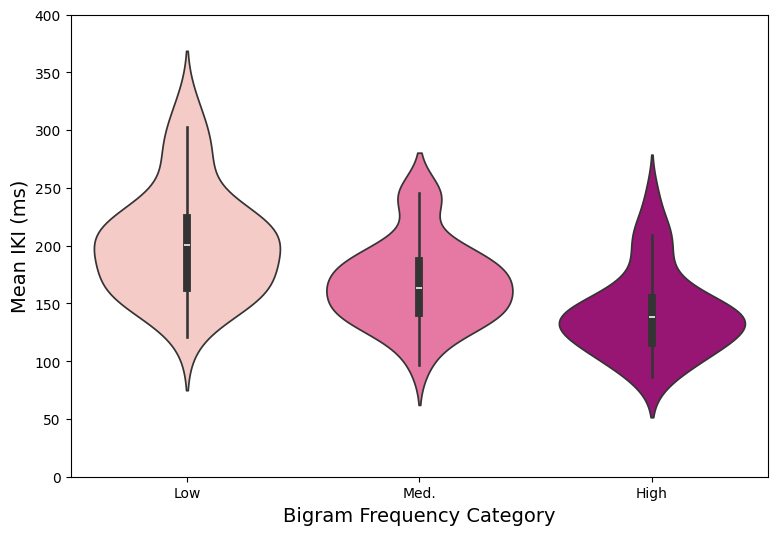

In [22]:
# Mean IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="mean_IKI", 
    hue='bf_type', 
    palette='RdPu'
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='Mean IKI (ms)',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

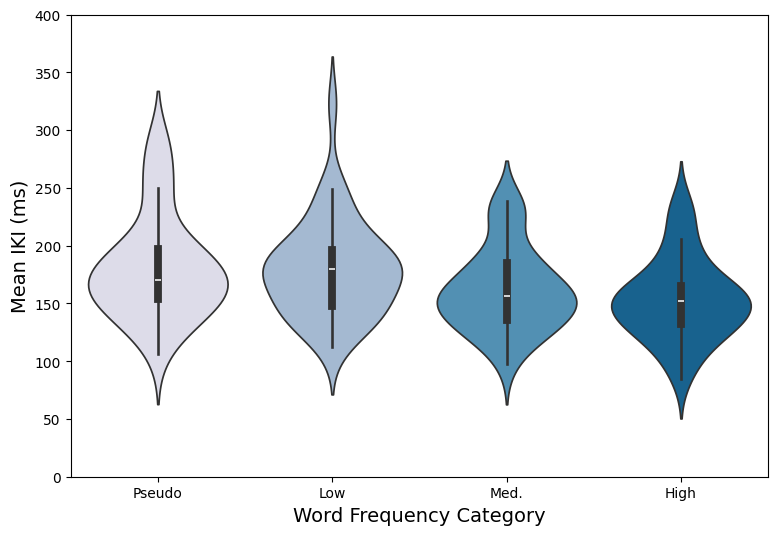

In [23]:
# Mean IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="mean_IKI", 
    hue='wf_type', 
    palette='PuBu'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='Mean IKI (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

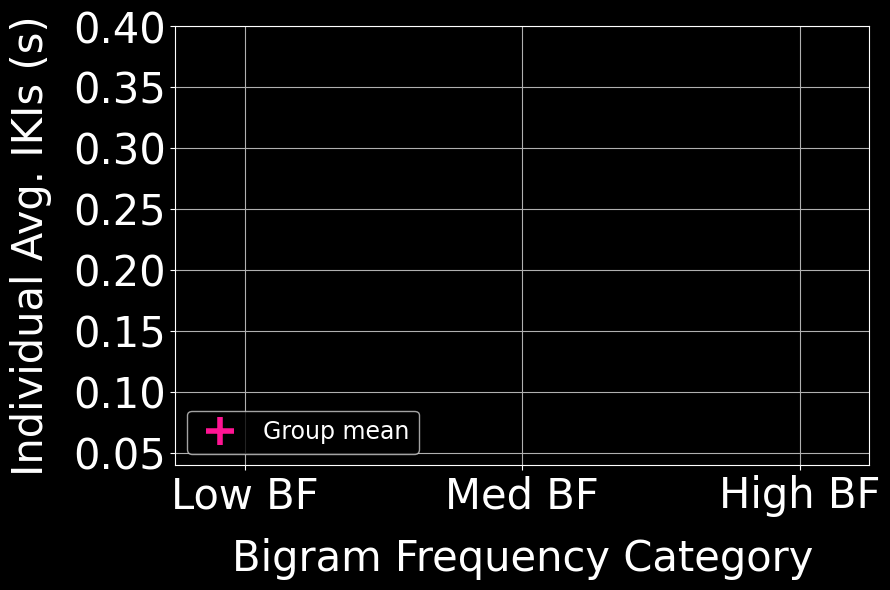

In [24]:
## individual IKI means by BF (correct trials only)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI'], 
     all_bybf[all_bybf['bf_type'] == 'med']['mean_IKI'],
     all_bybf[all_bybf['bf_type'] == 'high']['mean_IKI'])
means = (np.mean(all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI']),
         np.mean(all_bybf[all_bybf['bf_type'] == 'med']['mean_IKI']),
         np.mean(all_bybf[all_bybf['bf_type'] == 'high']['mean_IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.xlim([1.5, 6.5])
plt.ylim([0.04, 0.4])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Individual Avg. IKIs (s)", labelpad=15, size=30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'mean_ikis_corr_TESTWITHINDIVMEANS.png', dpi=300)
plt.show()

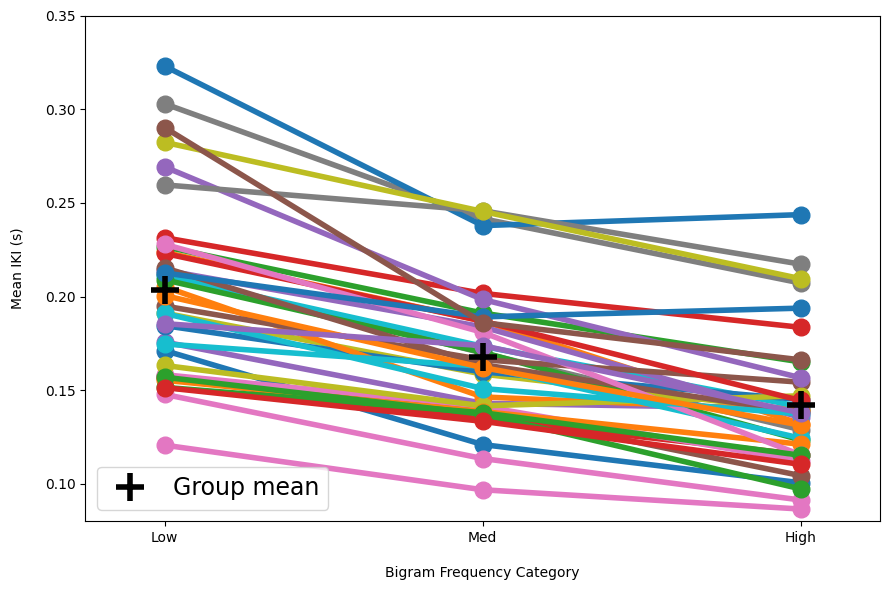

In [25]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.35])
plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Mean IKI (s)", labelpad=15)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

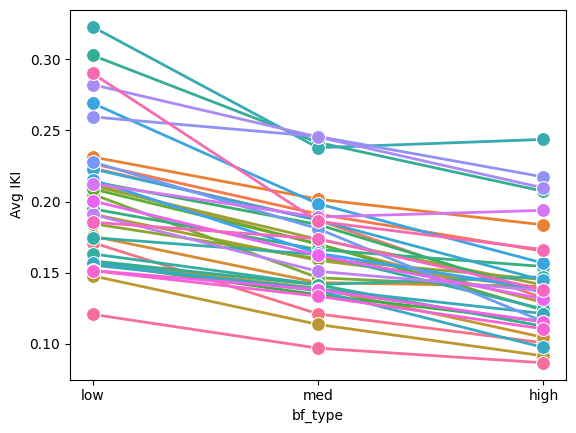

In [26]:
## seaborn version of individuals plot
data = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
                  indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

ax = sns.lineplot(data=data, x='bf_type', y='Avg IKI', hue='sID', marker = 'o', markersize = 10, linewidth = 2)
ax.get_legend().set_visible(False)
plt.show()

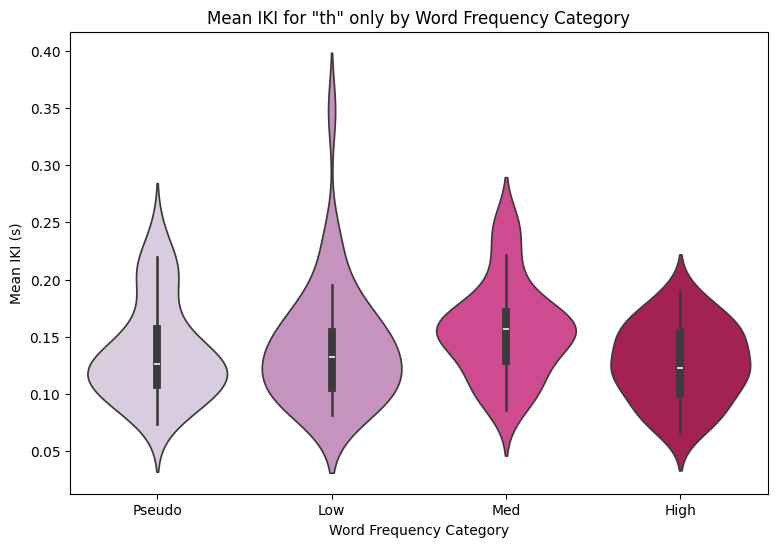

In [27]:
## Mean IKI for 'th' across WF (correct trials only)
# sns.set_style("ticks", rc=custom)
# sns.set_context('talk')
# plt.style.use("dark_background")

th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'he']

data = {'Pseudo' : indiv_meanikis(th_df, 'string', 'pseudo')['Avg IKI'],
        'Low': indiv_meanikis(th_df, 'string', 'lowwf')['Avg IKI'], 
        'Med': indiv_meanikis(th_df, 'string', 'medwf')['Avg IKI'],
        'High': indiv_meanikis(th_df, 'string', 'highwf')['Avg IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02,1)
plt.savefig(save_dir + 'violin_meanikis_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

<Figure size 640x480 with 0 Axes>

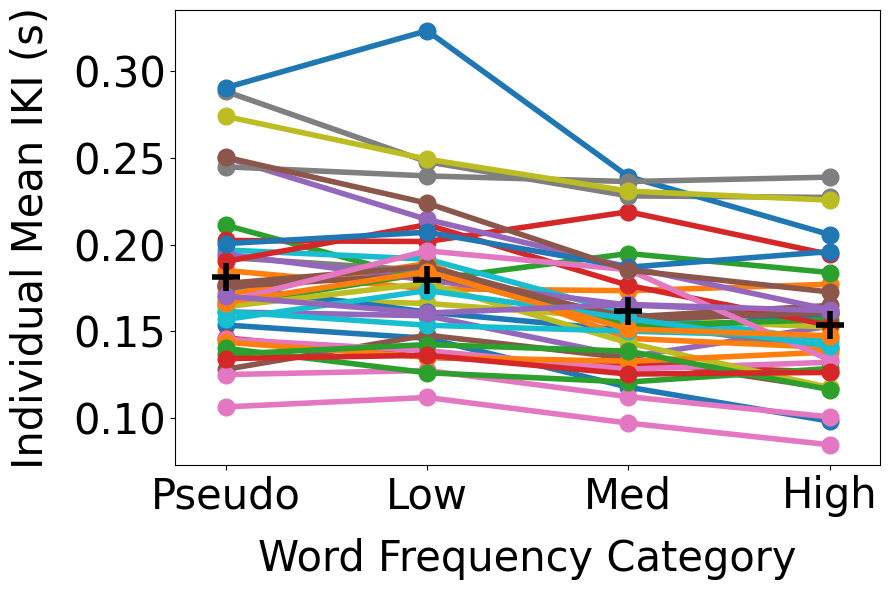

In [28]:
## individual IKI means by WF category
plt.rcParams.update(plt.rcParamsDefault)
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI'], 
     indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI'],
    indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI'])

means = (np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'pseudo')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'lowwf')['Avg IKI']), 
         np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'medwf')['Avg IKI']),
        np.mean(indiv_meanikis(corr_trials_bybg, 'string', 'highwf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Individual Mean IKI (s)", labelpad=15, fontsize = 30)
plt.title("")
# plt.legend(loc="best")

fig.tight_layout()
# plt.savefig(save_dir + 'indiv_mean_ikis.png', dpi=300)
plt.show()

In [29]:
np.sqrt(len(corr_trials_bybg.IKI))

181.5378748360793

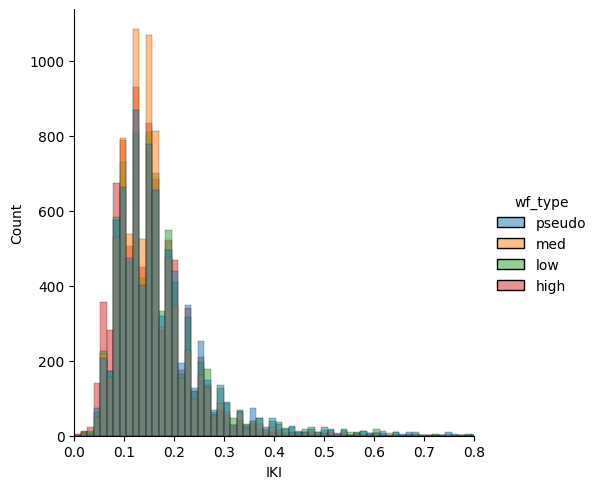

In [30]:
## histograms of mean IKI by WF
# sns.set(rc={"figure.figsize":(9, 6)})
sns.displot(corr_trials_bybg, x='IKI', hue='wf_type', bins=177)
plt.xlim(0, 0.8)
plt.show()

# SD IKI
___

## SD IKI Statistics

In [31]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'sd_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'sd_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  bf_type      2     72  39.372629  2.800259e-12  3.226178e-09  0.231282   

        eps  sphericity   W-spher  p-spher  
0  0.694938       False  0.561022  0.00004  


A    B     mean(A)     mean(B)       diff        se         T   p-tukey  \
0  high  low   69.205374  113.999678 -44.794304  8.539401 -5.245603  0.000002   
1  high  med   69.205374   75.103584  -5.898210  8.539401 -0.690705  0.769418   
2   low  med  113.999678   75.103584  38.896094  8.539401  4.554897  0.000041   

      cohen  
0 -1.104732  
1 -0.186322  
2  1.039201

In [32]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'sd_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'sd_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  avgbf_type      2     72  36.014136  1.444944e-11  5.737976e-10  0.199322   

        eps  sphericity   W-spher   p-spher  
0  0.828611       False  0.793161  0.017331  


A    B     mean(A)     mean(B)       diff        se         T   p-tukey  \
0  high  low   69.293221  109.351860 -40.058640  8.359277 -4.792118  0.000016   
1  high  med   69.293221   74.986914  -5.693694  8.359277 -0.681123  0.774977   
2   low  med  109.351860   74.986914  34.364946  8.359277  4.110995  0.000226   

      cohen  
0 -1.031135  
1 -0.179490  
2  0.930928

In [33]:
# Runs one-way, repeated measures ANOVA:
# individual SD IKI | word frequency
print(pg.rm_anova(all_bywf, 'sd_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'sd_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    108  27.60088  2.504769e-13  4.217216e-11  0.184601   

       eps  sphericity   W-spher  p-spher  
0  0.79937       False  0.594518  0.00289  


A       B     mean(A)     mean(B)       diff        se         T  \
0  high     low   66.216804  104.350453 -38.133650  8.387563 -4.546452   
1  high     med   66.216804   74.830512  -8.613709  8.387563 -1.026962   
2  high  pseudo   66.216804  103.303256 -37.086452  8.387563 -4.421601   
3   low     med  104.350453   74.830512  29.519941  8.387563  3.519490   
4   low  pseudo  104.350453  103.303256   1.047198  8.387563  0.124851   
5   med  pseudo   74.830512  103.303256 -28.472743  8.387563 -3.394639   

    p-tukey     cohen  
0  0.000067 -1.075150  
1  0.733939 -0.303264  
2  0.000112 -1.063710  
3  0.003215  0.792524  
4  0.999302  0.024708  
5  0.004872 -0.776369

## SD IKI Figures

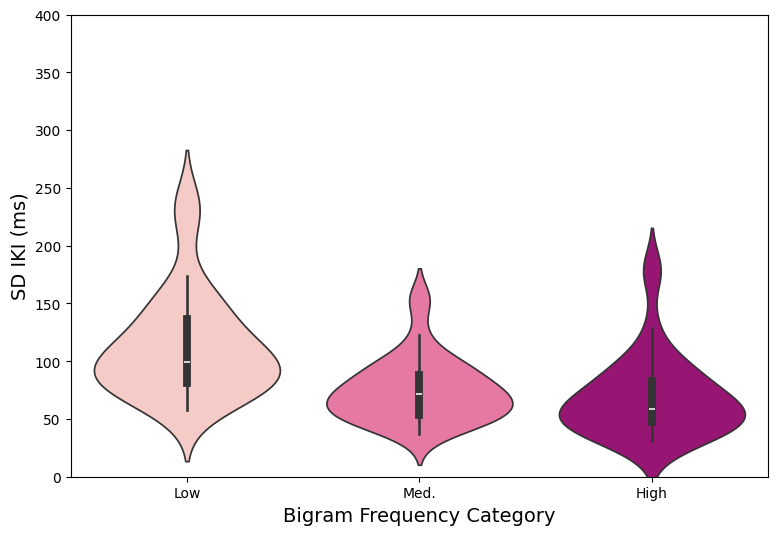

In [34]:
# SD IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="sd_IKI", 
    hue='bf_type', 
    palette='RdPu'
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='SD IKI (ms)',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

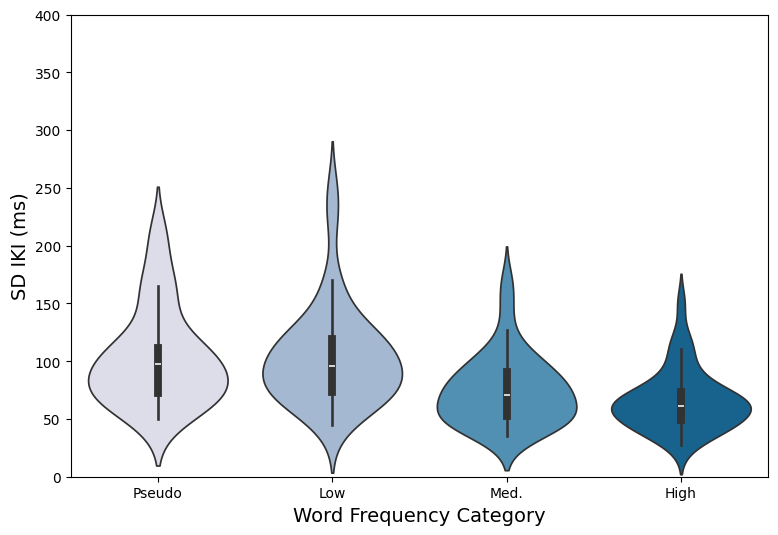

In [35]:
# SD IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="sd_IKI", 
    hue='wf_type', 
    palette='PuBu'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='SD IKI (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 400]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

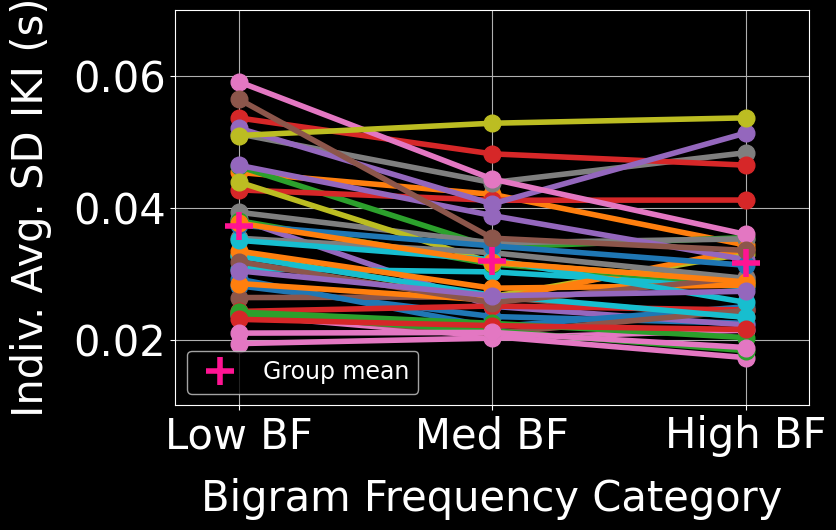

In [36]:
## individual MEAN SD IKI by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI'], 
     indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI'],
     indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI'])
means = (np.mean(indiv_sdikis(tight_bgs, 'bigram', 'lowbf_norep')['Avg SD IKI']), 
         np.mean(indiv_sdikis(tight_bgs, 'bigram', 'medbf_norep')['Avg SD IKI']),
         np.mean(indiv_sdikis(tight_bgs, 'bigram', 'highbf')['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')
ax.set_facecolor('black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([0.01, 0.07])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size=30)
plt.yticks(size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)
plt.ylabel("Indiv. Avg. SD IKI (s)", labelpad=15, size=30)
plt.grid(visible=None)

plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'meansds_bybf_corr.png', dpi=300, transparent = True)
plt.show()

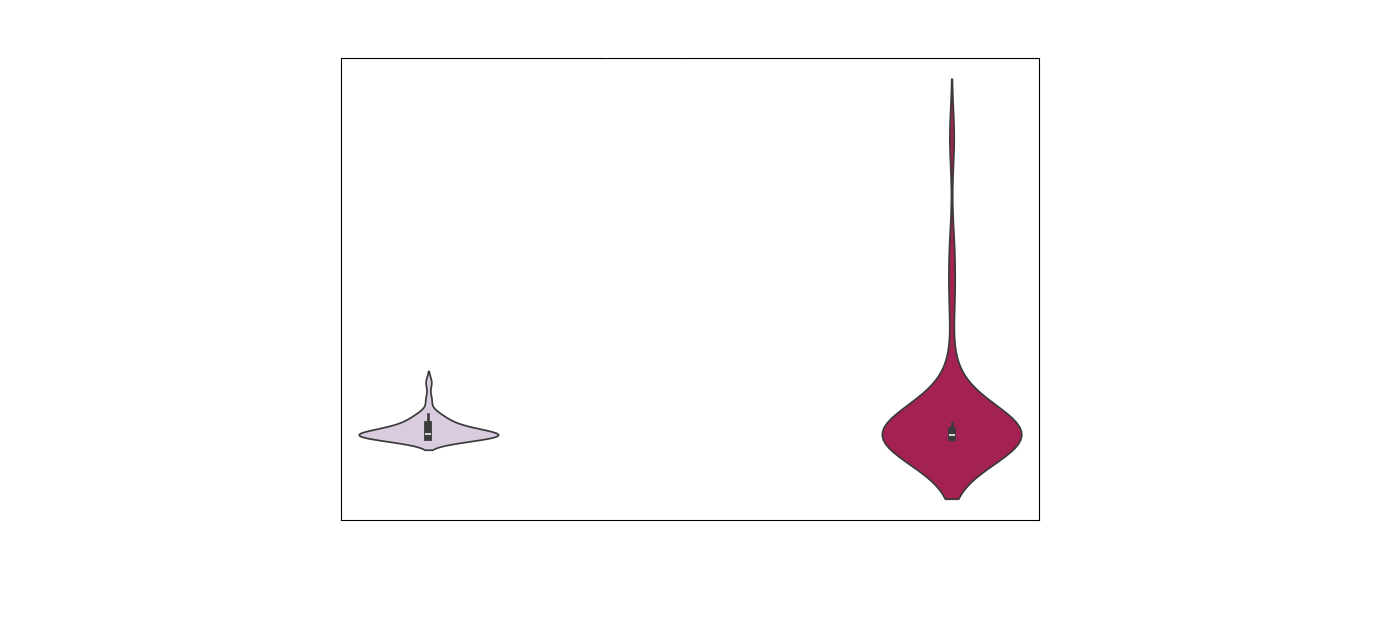

In [37]:
## mean CV IKI for 'th' by WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 're']

data = {'Pseudo' : indiv_sdikis(th_df, 'string', 'pseudo')['Avg SD IKI'], 
        'Low': indiv_sdikis(th_df, 'string', 'lowwf')['Avg SD IKI'], 
        'Med' : indiv_sdikis(th_df, 'string', 'medwf')['Avg SD IKI'],
        'High' : indiv_sdikis(th_df, 'string', 'highwf')['Avg SD IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean SD IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean SD IKI (s)')
ax.set(xlabel='Word Frequency Category')
# ax.set_ylim(-0.02, 0.30)

plt.savefig(save_dir + 'violin_meansds_thbywf_corr.png', dpi=300)
plt.show()

# CV IKI
___

## CV IKI Statistics

In [38]:
# Runs one-way, repeated measures ANOVA:
# individual CV IKI | bigram frequency
print(pg.rm_anova(all_bybf, 'cv_IKI', 'bf_type', 'sID'))
pg.pairwise_tukey(all_bybf, 'cv_IKI', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F    p-unc  p-GG-corr       ng2      eps  \
0  bf_type      2     72  8.836256  0.00037   0.002906  0.085715  0.61041   

   sphericity   W-spher       p-spher  
0       False  0.361756  1.871876e-08  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.482042  0.550194 -0.068153  0.034541 -1.973068  0.123818   
1  high  med  0.482042  0.441441  0.040601  0.034541  1.175418  0.470371   
2   low  med  0.550194  0.441441  0.108753  0.034541  3.148486  0.005968   

      cohen  
0 -0.410980  
1  0.256930  
2  0.927546

In [39]:
# Runs one-way, repeated measures ANOVA:
# individual mean CV | average bigram frequency
print(pg.rm_anova(all_byavgbf, 'cv_IKI', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_byavgbf, 'cv_IKI', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2         F    p-unc  p-GG-corr       ng2       eps  \
0  avgbf_type      2     72  2.679309  0.07545   0.091395  0.025431  0.756907   

   sphericity   W-spher   p-spher  
0       False  0.678834  0.001137  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  0.477443  0.522374 -0.044932  0.034939 -1.285998  0.406123   
1  high  med  0.477443  0.467257  0.010185  0.034939  0.291522  0.954254   
2   low  med  0.522374  0.467257  0.055117  0.034939  1.577520  0.259731   

      cohen  
0 -0.280131  
1  0.063027  
2  0.436996

In [40]:
## anova for cvs (by word freq)
print(pg.rm_anova(all_bywf, 'cv_IKI', 'wf_type', 'sID'))
pg.pairwise_tukey(all_bywf, 'cv_IKI', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  wf_type      3    108  19.962035  2.284787e-10  8.500167e-09  0.166947   

        eps  sphericity   W-spher   p-spher  
0  0.808876       False  0.679519  0.019829  


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.429179  0.570355 -0.141176  0.033103 -4.264688  0.000210   
1  high     med  0.429179  0.454306 -0.025127  0.033103 -0.759040  0.872651   
2  high  pseudo  0.429179  0.561804 -0.132625  0.033103 -4.006384  0.000566   
3   low     med  0.570355  0.454306  0.116049  0.033103  3.505648  0.003369   
4   low  pseudo  0.570355  0.561804  0.008551  0.033103  0.258304  0.993934   
5   med  pseudo  0.454306  0.561804 -0.107498  0.033103 -3.247344  0.007823   

      cohen  
0 -0.985066  
1 -0.186926  
2 -0.913209  
3  0.832020  
4  0.057034  
5 -0.760005

## CV IKI Figures

In [41]:
## making dataframe of cv values
cv_df = pd.concat(
    [indiv_cvikis(all_bigrams, 'bigram', 'highbf'),
    indiv_cvikis(all_bigrams, 'bigram', 'medbf').rename(columns = {'Avg CV IKI': 'meanCV_med'})['meanCV_med'],
    indiv_cvikis(all_bigrams, 'bigram', 'lowbf').rename(columns = {'Avg CV IKI': 'meanCV_low'})['meanCV_low']], 
    axis = 1)
cv_df = cv_df.rename(columns = {cv_df.columns[1]: 'meanCV_high'})
# cv_df

In [42]:
all_bybf.groupby('bf_type').cv_IKI.agg('std')

bf_type
high    0.196782
low     0.127576
med     0.105919
Name: cv_IKI, dtype: float64

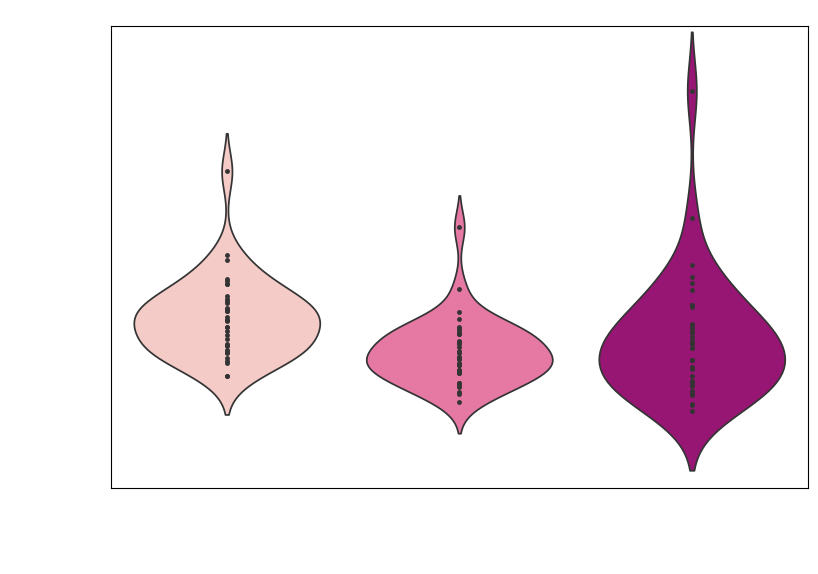

In [43]:
# CV IKI | Bigram Freq. - white background
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bybf, 
    x="bf_type", 
    y="cv_IKI", 
    hue='bf_type', 
    palette='RdPu',
    inner='point'
)

ax.set(
    xlabel='Bigram Frequency Category', 
    ylabel='CV IKI (ms)',
    xticks=[0, 1, 2],
    xticklabels=['Low', 'Med.', 'High'],
    ylim=[0, 1.5]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)
# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

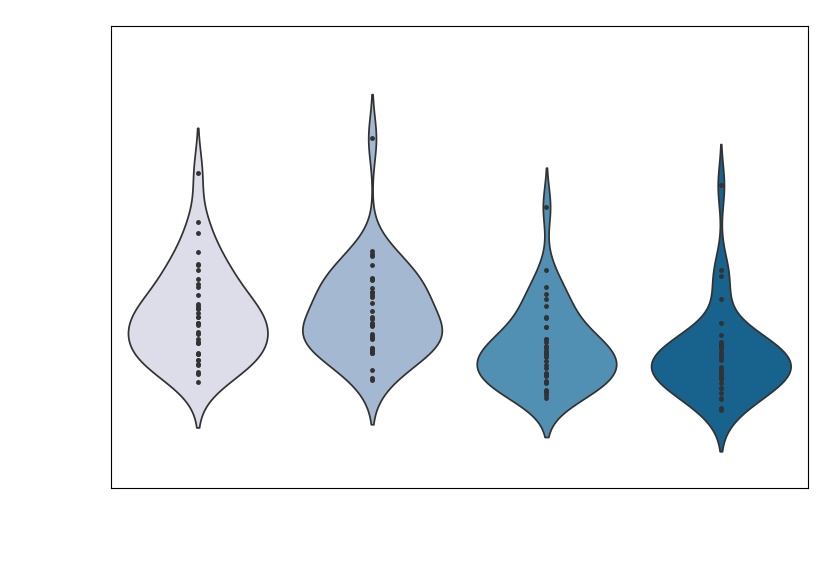

In [44]:
# CV IKI | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=all_bywf, 
    x="wf_type", 
    y="cv_IKI", 
    hue='wf_type', 
    palette='PuBu',
    inner='point'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='CV IKI (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 1.5]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

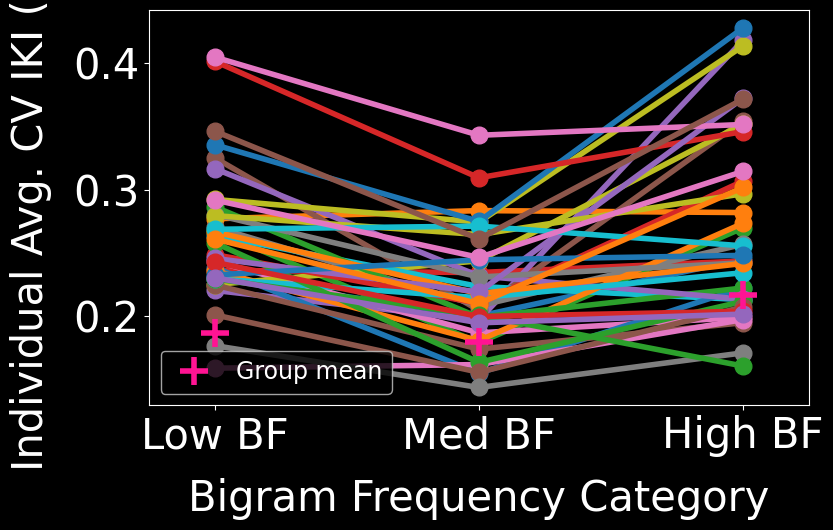

In [45]:
## Individual MEAN CV IKIs sorted by BF (correct trials)
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(tight_bgs, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(tight_bgs, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor = 'black')

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

# plt.ylim([0.1, 0.5])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'), size = 30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size = 30)
plt.yticks(size=30)
plt.ylabel("Individual Avg. CV IKI (%)", labelpad=15, size = 30)
plt.title("")
plt.legend(fontsize = 17, loc="lower left", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'cvikis_bybf_corr.png', dpi=300, transparent = True)
plt.show()

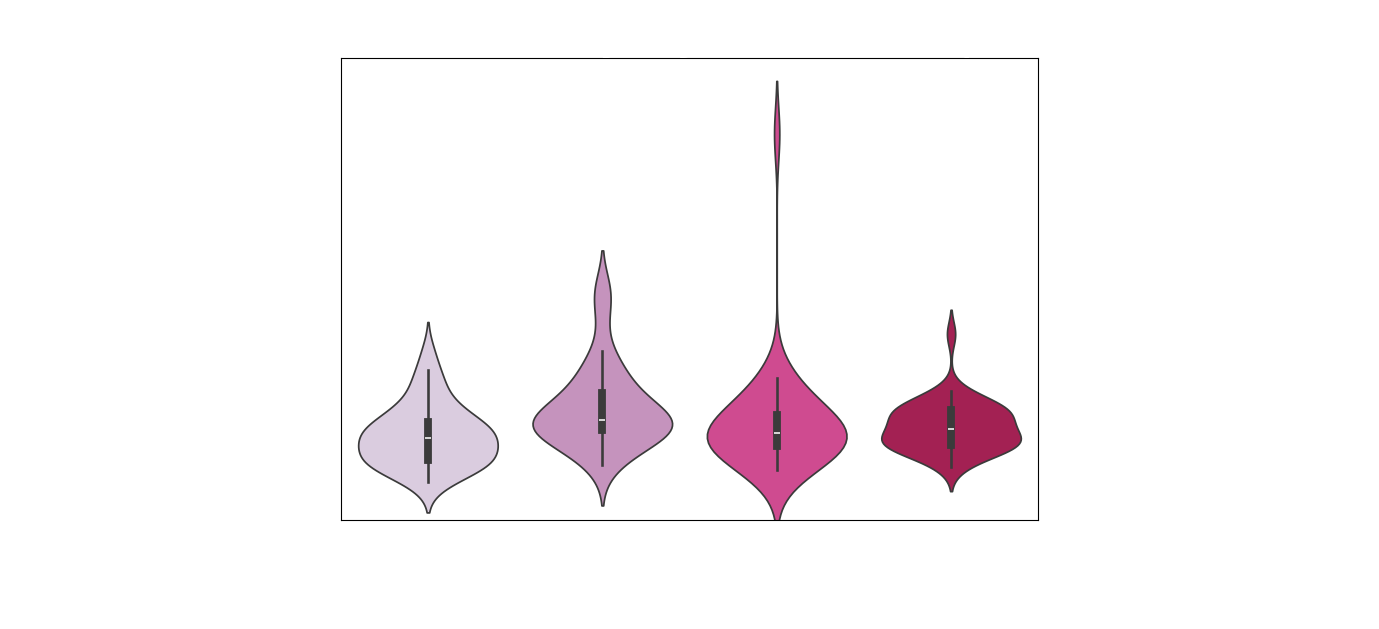

In [46]:
## Mean CV IKI for 'th' across WF (correct trials only)
th_df = corr_trials_bybg[corr_trials_bybg['bigram'] == 'th']

data = {'Pseudo' : indiv_cvikis(th_df, 'string', 'pseudo')['Avg CV IKI'], 
        'Low': indiv_cvikis(th_df, 'string', 'lowwf')['Avg CV IKI'], 
        'Med' : indiv_cvikis(th_df, 'string', 'medwf')['Avg CV IKI'],
        'High' : indiv_cvikis(th_df, 'string', 'highwf')['Avg CV IKI']}
DF = pd.DataFrame(data)

# sns.set(rc={"figure.figsize":(9, 6)})
fig, ax = plt.subplots(figsize=(9,6))
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='PuRd', ax=ax)
ax.set(title = 'Mean CV IKI for "th" only by Word Frequency Category')
ax.set(ylabel='Mean CV IKI (s)')
ax.set(xlabel='Word Frequency Category')
ax.set_ylim(-0.03, 1)

plt.savefig(save_dir + 'violin_meancvs_thbywf_corr.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

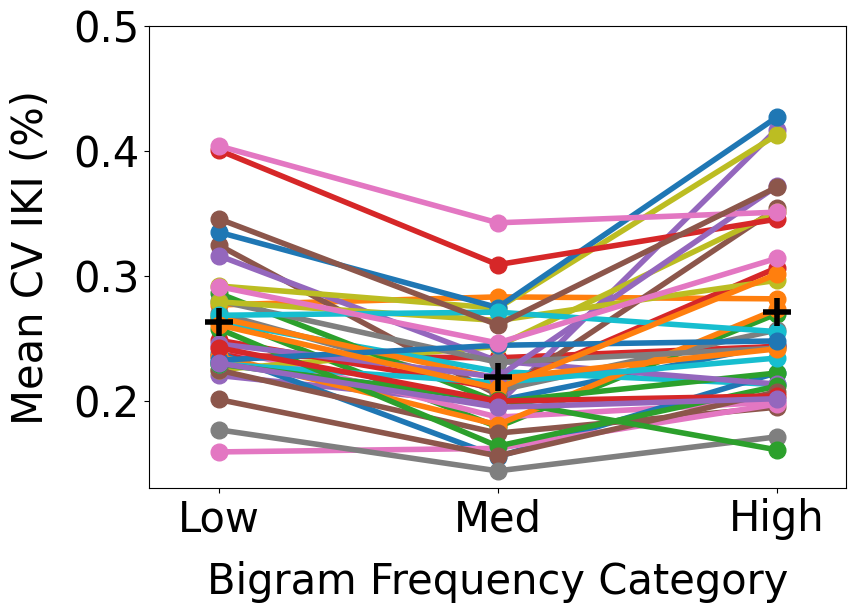

In [47]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.13, 0.5])
plt.xticks(x, ('Low', 'Med', 'High'), size=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, size=30)

plt.yticks(size=30)
plt.ylabel("Mean CV IKI (%)", labelpad=15, size=30)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

# Mean, SD, & CV RT

______

## RT Statistics

In [48]:
# ## NOT RELEVANT FOR MANUSCRIPT ##

# ## finding indices of trials that occur after an error
# err_indices = list(all_trials[all_trials['trial_corr'] == 'incorr'].index.values)
# posterr_indices = list(map(lambda x: x + 1, err_indices))

# ## making dataframe of only post-error trial reaction times
# all_rts = corr_trials[['sID', 'key_resp.rt.1', 'wf_type']]
# posterr_rts = all_rts.filter(posterr_indices, axis=0)

# ## making dataframe of only post-success trial reaction times
# all_indices = list(all_trials.index.values)
# bad_indices = (err_indices + posterr_indices)
# postsucc_indices = list(filter(lambda x: x not in set(bad_indices), all_indices))
# postsucc_rts = all_rts.filter(postsucc_indices, axis=0)

In [49]:
# Creates dataframes of RT metric values for average bigram and word frequencies.
rt_byavgbf = indiv_rtmetric(corr_trials, avgbf_groups, iki_metrics)
rt_bywf = indiv_rtmetric(corr_trials, wf_groups, iki_metrics)

In [50]:
# Runs one-way, repeated measures ANOVA:
# individual mean RT | word frequency
print(pg.rm_anova(rt_bywf, 'mean_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'mean_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2           F         p-unc       ng2      eps
0  wf_type      3    108  100.028566  4.793127e-31  0.137372  0.63048


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.744101  0.804358 -0.060257  0.034144 -1.764802  0.294584   
1  high     med  0.744101  0.777278 -0.033178  0.034144 -0.971699  0.765752   
2  high  pseudo  0.744101  0.899317 -0.155216  0.034144 -4.545946  0.000067   
3   low     med  0.804358  0.777278  0.027080  0.034144  0.793103  0.857484   
4   low  pseudo  0.804358  0.899317 -0.094959  0.034144 -2.781145  0.030900   
5   med  pseudo  0.777278  0.899317 -0.122039  0.034144 -3.574248  0.002669   

      cohen  
0 -0.437389  
1 -0.260372  
2 -0.990010  
3  0.198803  
4 -0.578997  
5 -0.785219

In [51]:
# Runs one-way, repeated measures ANOVA:
# individual SD RT | word frequency
print(pg.rm_anova(rt_bywf, 'sd_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'sd_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  12.163672  6.420221e-07  0.097355  0.812984


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.125311  0.139880 -0.014569  0.013401 -1.087162  0.697935   
1  high     med  0.125311  0.137663 -0.012352  0.013401 -0.921742  0.793270   
2  high  pseudo  0.125311  0.175456 -0.050145  0.013401 -3.741929  0.001487   
3   low     med  0.139880  0.137663  0.002217  0.013401  0.165420  0.998383   
4   low  pseudo  0.139880  0.175456 -0.035576  0.013401 -2.654767  0.043319   
5   med  pseudo  0.137663  0.175456 -0.037793  0.013401 -2.820186  0.027753   

      cohen  
0 -0.258004  
1 -0.228312  
2 -0.884407  
3  0.037852  
4 -0.583487  
5 -0.642874

In [52]:
# Runs one-way, repeated measures ANOVA:
# individual CV RT | word frequency
print(pg.rm_anova(rt_bywf, 'cv_RT', 'wf_type', 'sID'))
pg.pairwise_tukey(rt_bywf, 'cv_RT', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc       ng2       eps
0  wf_type      3    108  2.975354  0.034863  0.038017  0.829925


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  0.164215  0.167759 -0.003544  0.012713 -0.278762  0.992408   
1  high     med  0.164215  0.173048 -0.008833  0.012713 -0.694809  0.898935   
2  high  pseudo  0.164215  0.192015 -0.027799  0.012713 -2.186728  0.131831   
3   low     med  0.167759  0.173048 -0.005289  0.012713 -0.416047  0.975654   
4   low  pseudo  0.167759  0.192015 -0.024255  0.012713 -1.907966  0.229267   
5   med  pseudo  0.173048  0.192015 -0.018966  0.012713 -1.491919  0.445023   

      cohen  
0 -0.064605  
1 -0.156128  
2 -0.527708  
3 -0.093432  
4 -0.460116  
5 -0.347975

## RT Figures

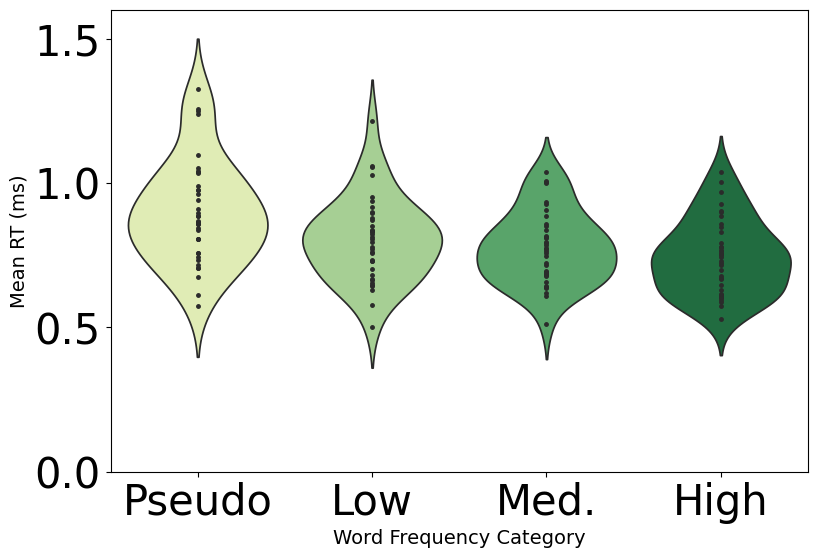

In [53]:
# Mean RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="mean_RT", 
    hue='wf_type', 
    palette='YlGn',
    inner='point'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='Mean RT (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 1.6]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

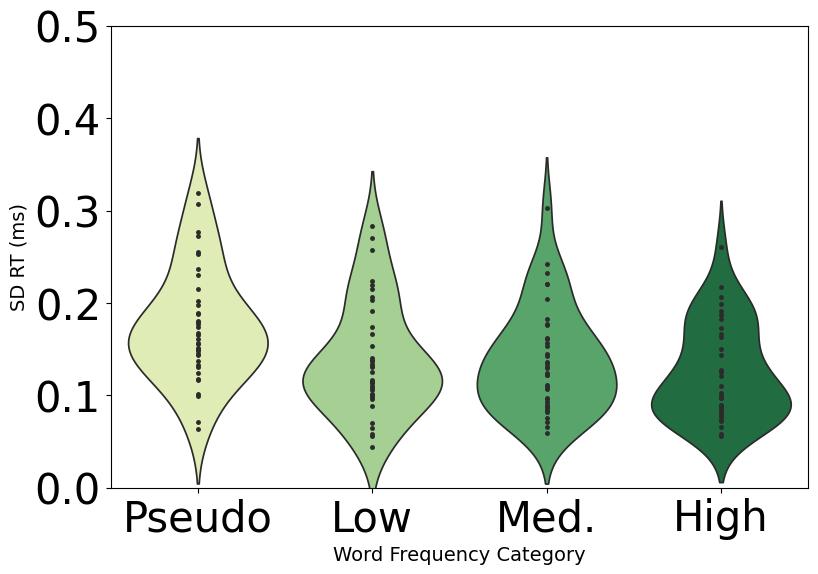

In [54]:
# SD RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="sd_RT", 
    hue='wf_type', 
    palette='YlGn',
    inner='point'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='SD RT (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 0.5]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

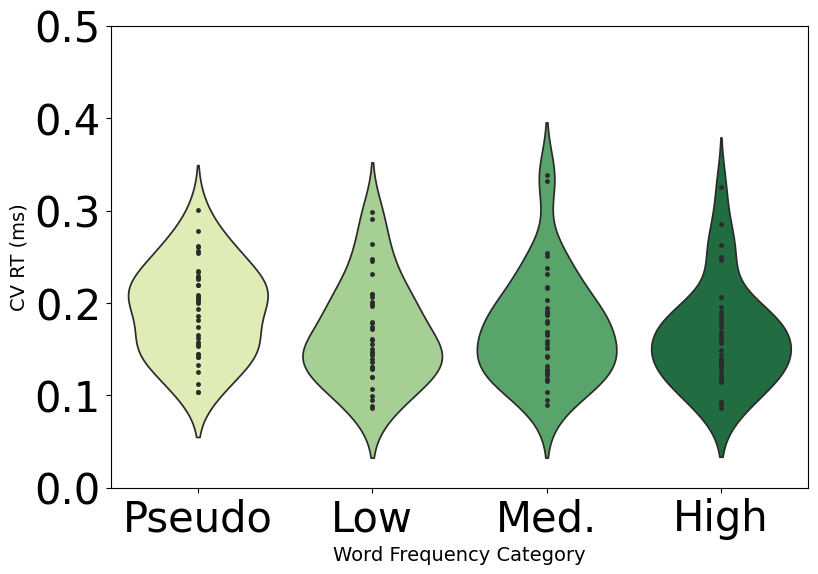

In [55]:
# CV RT | Word Freq. - white background 
fig, ax = plt.subplots(figsize=(9,6))
sns.violinplot(
    data=rt_bywf, 
    x="wf_type", 
    y="cv_RT", 
    hue='wf_type', 
    palette='YlGn',
    inner='point'
)

ax.set(
    xlabel='Word Frequency Category', 
    ylabel='CV RT (ms)',
    xticks=[0, 1, 2, 3],
    xticklabels=['Pseudo', 'Low', 'Med.', 'High'],
    ylim=[0, 0.5]
)
ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

# plt.savefig(save_dir + 'violin_meanikis_bf_corr.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

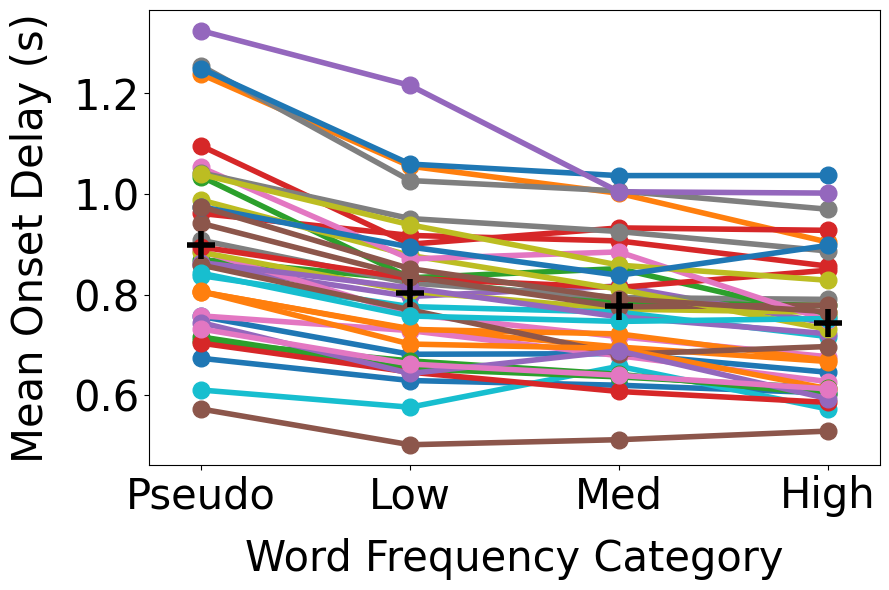

In [56]:
## plotting average onset delays by WF group
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (rt_bywf[rt_bywf['wf_type'] == 'pseudo']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'low']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'med']['mean_RT'],
    rt_bywf[rt_bywf['wf_type'] == 'high']['mean_RT'])

means = (np.mean(rt_bywf[rt_bywf['wf_type'] == 'pseudo']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'low']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'med']['mean_RT']),
        np.mean(rt_bywf[rt_bywf['wf_type'] == 'high']['mean_RT']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_bywf.png', dpi=300)
plt.show()

# Total Trial Error
___

## Total Trial Error Statistics

In [57]:
## anova for error rates (by bg freq)
all_errors_bybf = all_ikimetric(indiv_error, incorr_bgs, 
                                   'bigram', bf_groups)

print(pg.rm_anova(all_errors_bybf, 'total_error', 'bf_type', 'sID'))

# pg.pairwise_tukey(all_errors_bybf, 'Total Error', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  bf_type      2     72  2.547467  0.085318   0.103096  0.022504  0.728648   

   sphericity   W-spher   p-spher  
0       False  0.627596  0.000288  


In [58]:
## anova for error rates (by avg bg freq)
all_errors_byavgbf = all_ikimetric(indiv_error, incorr_trials, 
                                   'string', avgbf_groups)

print(pg.rm_anova(all_errors_byavgbf, 'total_error', 'avgbf_type', 'sID'))

pg.pairwise_tukey(all_errors_byavgbf, 'total_error', 
                  'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2  \
0  avgbf_type      2     72  7.416892  0.001178   0.002775  0.061364   

        eps  sphericity   W-spher   p-spher  
0  0.797694       False  0.746387  0.005982  


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low  4.756757  7.135135 -2.378378  0.922474 -2.578259  0.030087   
1  high  med  4.756757  5.432432 -0.675676  0.922474 -0.732460  0.744797   
2   low  med  7.135135  5.432432  1.702703  0.922474  1.845799  0.159754   

      cohen  
0 -0.590727  
1 -0.189652  
2  0.397755

In [59]:
## anova for error rates (by word freq)
all_errors_bywf = all_ikimetric(indiv_error, incorr_trials, 
                                'string', wf_groups)

print(pg.rm_anova(all_errors_bywf, 'total_error', 'wf_type', 'sID'))

pg.pairwise_tukey(all_errors_bywf, 'total_error', 
                  'wf_type', effsize='cohen')

    Source  ddof1  ddof2        F     p-unc  p-GG-corr       ng2       eps  \
0  wf_type      3    108  2.91098  0.037805   0.050875  0.030106  0.791766   

   sphericity   W-spher   p-spher  
0       False  0.679477  0.019812  


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low  3.486486  4.675676 -1.189189  0.728268 -1.632899  0.363508   
1  high     med  3.486486  4.243243 -0.756757  0.728268 -1.039118  0.726772   
2  high  pseudo  3.486486  4.918919 -1.432432  0.728268 -1.966902  0.205409   
3   low     med  4.675676  4.243243  0.432432  0.728268  0.593782  0.933819   
4   low  pseudo  4.675676  4.918919 -0.243243  0.728268 -0.334002  0.987107   
5   med  pseudo  4.243243  4.918919 -0.675676  0.728268 -0.927784  0.790011   

      cohen  
0 -0.409447  
1 -0.252632  
2 -0.427069  
3  0.149436  
4 -0.074533  
5 -0.202001

## Trial Error Figures

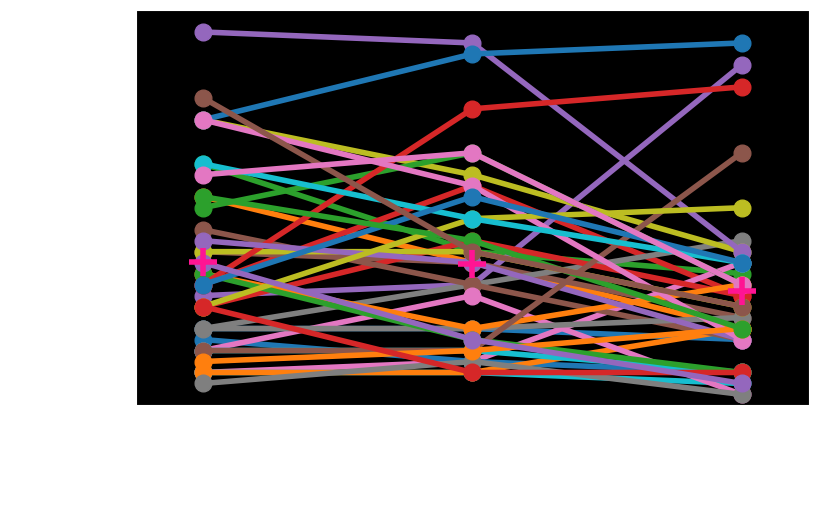

In [60]:
## Individual total trial error by bigram BF
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_bgs, 'bigram', 'lowbf')['total_error'], 
     indiv_error(incorr_bgs, 'bigram', 'medbf')['total_error'],
     indiv_error(incorr_bgs, 'bigram', 'highbf')['total_error'])

means = (np.mean(indiv_error(incorr_bgs, 'bigram', 'lowbf')['total_error']), 
         np.mean(indiv_error(incorr_bgs, 'bigram', 'medbf')['total_error']),
         np.mean(indiv_error(incorr_bgs, 'bigram', 'highbf')['total_error']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'deeppink', label = 'Group mean')

plt.ylim([-1, 35])
plt.xlim([1.5, 6.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
plt.ylabel("Indiv. Total Error", labelpad=15)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'meanerr_bybf.png', dpi=300)
plt.show()

In [61]:
## Individual total trial error by AVG BF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6]
# D = (indiv_error(incorr_trials, 'string', 'avg_lowbf')['Total Error'], 
#      indiv_error(incorr_trials, 'string', 'avg_medbf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'avg_highbf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 6.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
# plt.xlabel("Average Bigram Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# plt.savefig(save_dir + 'indiv_sdikis.png', dpi=300)
# plt.show()

In [62]:
## Individual total trial error by WF
# plt.rcParams['font.size'] = '30'
# x = [2, 4, 6, 8]

# D = (indiv_error(incorr_trials, 'string', 'pseudo')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'lowwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'medwf')['Total Error'],
#      indiv_error(incorr_trials, 'string', 'highwf')['Total Error'])

# fig, ax = plt.subplots(figsize=(9, 6))

# print([len(x) for x in D])
# ax.plot(x, D, '.-', linewidth = 2.5, ms = 20)

# plt.xlim([1.5, 8.5])
# # plt.xticks(x, ('', '', ''))
# plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'))
# plt.xlabel("Word Frequency Category", labelpad=15)
# plt.ylabel("Indiv. Total Error", labelpad=15)

# plt.title("")
# # plt.legend(loc="best")

# ax.set_facecolor('black')
# plt.rc('text', color='white')
# plt.rc('axes', labelcolor='white')
# plt.rc('xtick', color='white')
# plt.rc('ytick', color='white')

# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('white')

# fig.tight_layout()
# # plt.savefig(save_dir + 'indiv_sdikis.png', dpi=300)
# plt.show()

# Delta RT

In [63]:
# Calculates the change in reaction time (delta RT) across consecutive 
# repetitions of the same string.
def deltart(dataframe):
    deltarts = pd.DataFrame(dataframe.groupby(['sID', 
                                               'string']).RT.agg(['diff']))
    return deltarts

# Adding 'delta_rt' column to corr_trials dataframe.
corr_trials = corr_trials.assign(delta_rt=deltart(corr_trials))

# Averages delta RTs across frequency groups for each subject and puts into 
# one dataframe.
def indiv_deltart(dataframe, typ_group_list):
    all_deltarts = pd.DataFrame()
    for typ_group in typ_group_list:
        group = getattr(typ, typ_group)
        DF = dataframe[dataframe.string.isin(group)]
        delta_DF = pd.DataFrame(DF)
        delta_DF['delta_rt'] = deltart(DF)
        delta_DF = delta_DF[delta_DF['rep_num'] != 0]
        mean_byindiv = delta_DF.groupby(['sID']).delta_rt.agg(['mean'])
        # mean_byindiv = pd.DataFrame(delta_DF.groupby('sID').agg('mean'))
        mean_deltarts = mean_byindiv.rename(columns={'mean' : 'mean_deltart'}).reset_index()
        if 'avg' in typ_group:
            freq_type = typ_group
            exclude_chars = ['avg_', 'bf']
            for char in exclude_chars:
                freq_type = freq_type.replace(char, "")
            mean_deltarts['avgbf_type'] = freq_type
        else:
            freq_type = typ_group.replace('wf', "")
            mean_deltarts['wf_type'] = freq_type
        all_deltarts = pd.concat([all_deltarts, mean_deltarts])
    return all_deltarts

## Delta RT Statistics

In [64]:
## anova on delta reaction time across avg BF
all_deltarts_byavgbf = indiv_deltart(corr_trials, avgbf_groups)

print(pg.rm_anova(all_deltarts_byavgbf, 'mean_deltart', 'avgbf_type', 'sID'))
pg.pairwise_tukey(all_deltarts_byavgbf, 'mean_deltart', 'avgbf_type', effsize='cohen')

       Source  ddof1  ddof2        F     p-unc       ng2       eps
0  avgbf_type      2     72  0.31445  0.731188  0.002566  0.968921


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.015252 -0.013990 -0.001262  0.002565 -0.492125  0.875210   
1  high  med -0.015252 -0.014202 -0.001050  0.002565 -0.409481  0.911803   
2   low  med -0.013990 -0.014202  0.000212  0.002565  0.082644  0.996242   

      cohen  
0 -0.104976  
1 -0.099204  
2  0.020355

In [65]:
## anova on delta reaction time across WF
all_deltarts_bywf = indiv_deltart(corr_trials, wf_groups)

print(pg.rm_anova(all_deltarts_bywf, 'mean_deltart', 'wf_type', 'sID'))
pg.pairwise_tukey(all_deltarts_bywf, 'mean_deltart', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2       eps
0  wf_type      3    108  12.448844  4.705486e-07  0.152644  0.878072


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.009020 -0.016393  0.007373  0.003154  2.337706  0.094349   
1  high     med -0.009020 -0.009907  0.000887  0.003154  0.281398  0.992195   
2  high  pseudo -0.009020 -0.023123  0.014103  0.003154  4.471684  0.000091   
3   low     med -0.016393 -0.009907 -0.006485  0.003154 -2.056308  0.172599   
4   low  pseudo -0.016393 -0.023123  0.006730  0.003154  2.133978  0.147335   
5   med  pseudo -0.009907 -0.023123  0.013216  0.003154  4.190286  0.000280   

      cohen  
0  0.535470  
1  0.069590  
2  0.961021  
3 -0.524864  
4  0.469613  
5  0.989294

## Delta RT Figures

<Figure size 640x480 with 0 Axes>

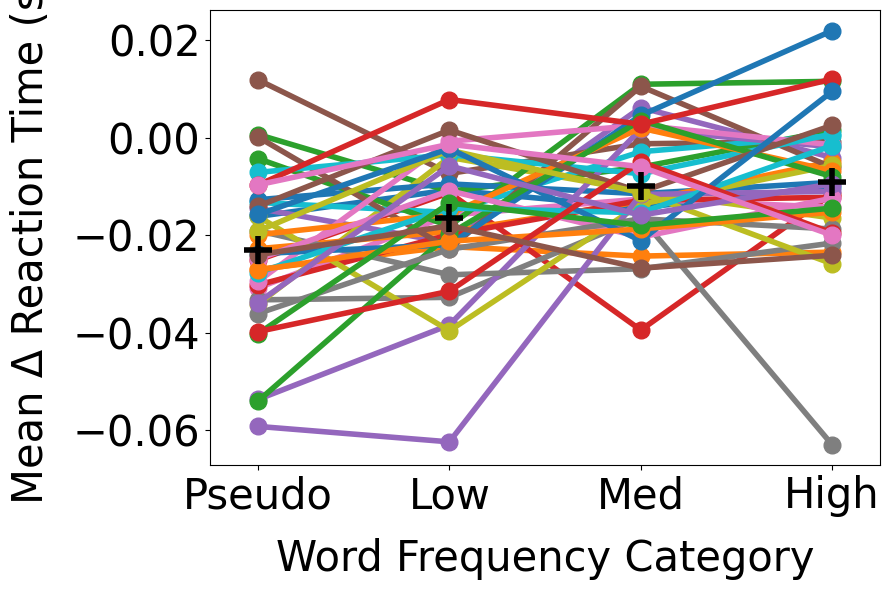

In [66]:
## plotting mean delta onset delays across WF
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')
# plt.rcParams['font.size'] = '30']

x = [2, 4, 6, 8]
D = (all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'pseudo']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'low']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'med']['mean_deltart'],
    all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']['mean_deltart'])

means = (np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'pseudo']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'low']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'med']['mean_deltart']),
        np.mean(all_deltarts_bywf[all_deltarts_bywf['wf_type'] == 'high']['mean_deltart']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-1, 30])
plt.xlim([1.5, 8.5])
# plt.xticks(x, ('', '', ''))
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize = 30)
plt.ylabel("Mean Δ Reaction Time (s)", labelpad=15, fontsize = 30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaRT_bywf.png', dpi=300)
plt.show()

In [67]:
pseudo_only = corr_trials[corr_trials['wf_type'] == 'pseudo']
pseudo_rts = pseudo_only.groupby(['sID', 'rep_num']).RT.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

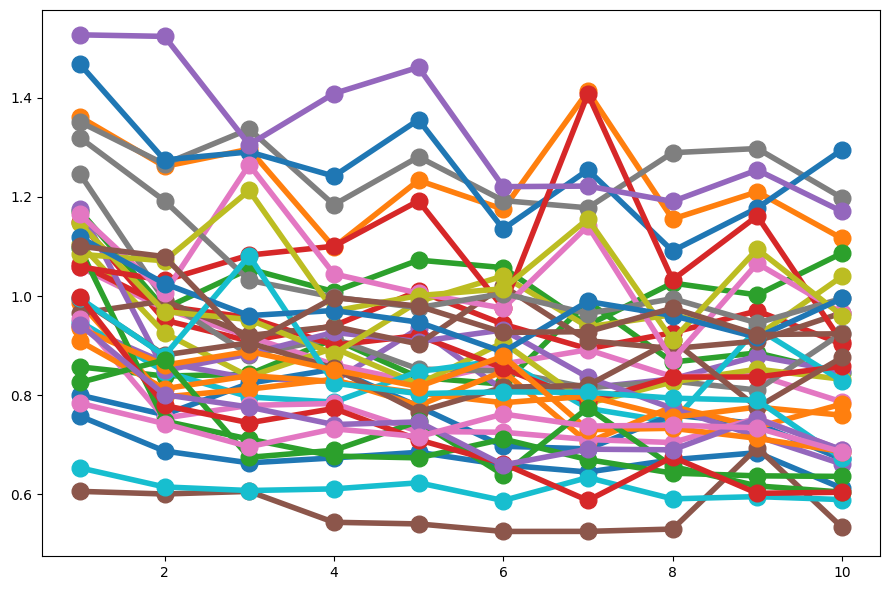

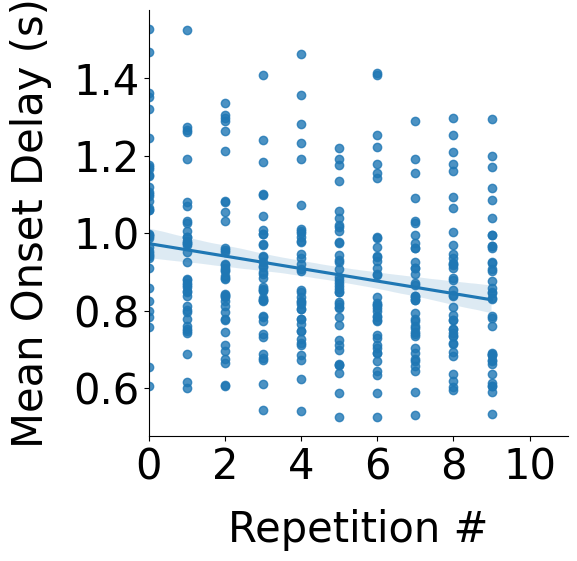

In [68]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_rts[pseudo_rts['rep_num'] == 0]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 1]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 2]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 3]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 4]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 5]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 6]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 7]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 8]['mean'],
    pseudo_rts[pseudo_rts['rep_num'] == 9]['mean'])

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
sns.lmplot(x="rep_num", y="mean", data=pseudo_rts)

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Onset Delay (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meanod_byrep.png', dpi=300)
plt.show()

In [69]:
## pearson correlation for 
print(pearsonr(pseudo_rts['mean'], pseudo_rts['rep_num']))

PearsonRResult(statistic=-0.23520313511420687, pvalue=4.802645450556083e-06)


## High WF RTs vs. Simulated Null

In [ ]:
# Randomly shuffles the RT or IKI values for high freq. bigrams or words and 
# calculates the mean delta RT/IKI of each random reshuffle.

def null_deltas(dataframe, metric_column):
    rep_num = 1000
    shuff_means = []
    for n in range(0, rep_num):
        if 'RT' in metric_column:
            shuff = pd.DataFrame(dataframe[dataframe['wf_type'] == 'highwf'])
            shuff_vals = np.random.permutation(shuff[metric_column])
            shuff[metric_column] = shuff_vals
            shuff_deltas = deltart(shuff)
            # print(shuff_deltas)
            shuff['delta_rt'] = shuff_deltas
            shuff_mean = np.mean(shuff['delta_rt'])
            shuff_means.append([shuff_mean])
        if 'IKI' in metric_column:
            for bg_word in ['bf_type', 'wf_type']:
                shuff = pd.DataFrame(dataframe[dataframe[bg_word] == 'high'])
                # shuff = shuff.reset_index(drop=True)
                shuff_vals = np.random.permutation(shuff[metric_column])
                shuff[metric_column] = shuff_vals
                shuff_deltas = deltaiki(shuff)
                shuff['delta_iki'] = shuff_deltas
                shuff_mean = np.mean(shuff['delta_iki'])
                shuff_means.append([bg_word, shuff_mean])
    shuff_means = pd.DataFrame(shuff_means)
    # shuff_means.to_csv(save_dir + '/shuff_means_ADDDATEHERE.csv')
    return shuff_means

Average of shuffled mean delta RTs -3.4555731851798887e-05
Mean delta RT of collected high freq. words -0.009137092399837328
estimated p-val: 0.0


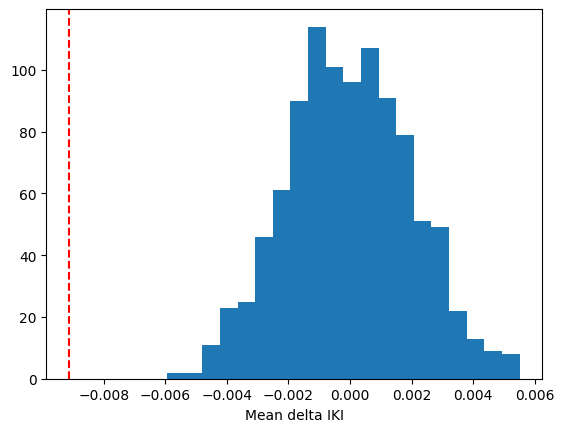

In [99]:
# Plotting mean delta RTs of shuffled data and observed value for high freq.
# words.

highrt_mean = corr_trials[corr_trials['wf_type'] == 'highwf'].delta_rt.mean()
shuff_rt = null_deltas(corr_trials, 'RT')

print('Average of shuffled mean delta RTs', np.mean(shuff_rt))
print('Mean delta RT of collected high freq. words', highrt_mean)
print('estimated p-val:', np.mean(abs(shuff_rt) > abs(highrt_mean)))

plt.hist(shuff_rt, bins=20)
plt.axvline(x=highrt_mean, color='red', linestyle='--')

plt.xlabel("Mean delta IKI")
plt.title("")

plt.show()

# Delta IKI

In [70]:
# Defining function that calcuates delta IKI from a given dataframe.
def deltaiki(dataframe):
    deltaikis = pd.DataFrame(dataframe.groupby(['sID', 
                                                'string', 
                                                'bigram']).IKI.agg(['diff']))
    deltaikis.fillna(0, inplace=True)
    return deltaikis

# Adding delta IKI column to corr_trials_bybg dataframe.
corr_trials_bybg = corr_trials_bybg.assign(delta_iki=deltaiki(corr_trials_bybg))

# 
def indiv_meandeltaiki(dataframe, str_or_bg, typ_group_list):
    all_means = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        delta_DF = pd.DataFrame(DF)
        delta_DF['delta_iki'] = deltaiki(DF)
        delta_DF = delta_DF[delta_DF['rep_num'] != 0]
        deltas = delta_DF.groupby(['sID', 
                                   'string', 
                                   'bigram']).delta_iki.agg(['mean']).reset_index()
        deltas = deltas.rename(columns={'mean' : 'mean_deltaiki'})
        mean_deltaikis = deltas.groupby('sID').mean_deltaiki.agg(['mean']).reset_index()
        mean_deltaikis = mean_deltaikis.rename(columns={'mean' : 'mean_deltaiki'})
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                mean_deltaikis['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                mean_deltaikis['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             mean_deltaikis['bf_type'] = freq_type
        all_means = pd.concat([all_means, mean_deltaikis])
    all_means = all_means.rename(columns = {'mean': 'mean_IKI',
                                                'stdev': 'sd_IKI',
                                                'variation': 'cv_IKI'})
    return all_means.reset_index()

In [71]:
### TESTING CELL ###


# # # calulating s009s mean IKI for low freq. bigrams using groupby
# test = corr_trials_bybg[(corr_trials_bybg['sID'] == 's009') & (corr_trials_bybg['bf_type'] == 'low')]
# test2 = test.groupby(['string', 'bigram']).delta_iki.agg('mean')
# print(np.mean(test2))
# print(test2)

# # calulating s009s mean IKI for low freq. bigrams using for loops and filtering
# examine = corr_trials_bybg[(corr_trials_bybg['sID'] == 's009') & (corr_trials_bybg['bf_type'] == 'low')]
# another = deltaiki(examine)

# examine2 = []
# for string in another.string.unique():
#     for bigram in another.bigram.unique():
#         filtered = another[(another['string'] == string) & (another['bigram'] == bigram)]
#         filtered_mean = np.mean(filtered['delta_iki'])
#         if math.isnan(filtered_mean) == False:
#             meannfrends = filtered_mean
#             examine2.append(meannfrends)

# examine2
# np.mean(examine2)
# # examine3 = examine2.IKI.mean()
# # examine3
# # np.mean(examine2)

In [72]:
## making dataframe of all individual mean delta IKIs
all_deltas_bybf = indiv_meandeltaiki(corr_trials_bybg, 'bigram', bf_groups)
all_deltas_bywf = indiv_meandeltaiki(corr_trials_bybg, 'string', wf_groups)
all_deltas_bybf

index   sID  mean_deltaiki bf_type
0        0  s009      -0.005433     low
1        1  s020      -0.001439     low
2        2  s175      -0.003513     low
3        3  s176      -0.007789     low
4        4  s178      -0.000970     low
..     ...   ...            ...     ...
106     32  s304      -0.000128    high
107     33  s305      -0.003082    high
108     34  s306      -0.002553    high
109     35  s309      -0.002228    high
110     36  s311      -0.002414    high

[111 rows x 4 columns]

## Delta IKI Statistics

In [73]:
## anova on delta iki comparisons across BF
print(pg.rm_anova(all_deltas_bybf, 'mean_deltaiki', 'bf_type', 'sID', correction=True))
pg.pairwise_tukey(all_deltas_bybf, 'mean_deltaiki', 'bf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  bf_type      2     72  30.645999  2.349757e-10  3.303016e-09  0.213533   

        eps  sphericity  W-spher  p-spher  
0  0.859151        True      inf      1.0  


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high  low -0.001425 -0.005162  0.003737  0.000747  5.000566  0.000007   
1  high  med -0.001425 -0.001949  0.000524  0.000747  0.700844  0.763498   
2   low  med -0.005162 -0.001949 -0.003213  0.000747 -4.299723  0.000111   

      cohen  
0  1.052312  
1  0.200272  
2 -0.945682

In [74]:
## anova on delta iki comparisons across WF
print(pg.rm_anova(all_deltas_bywf, 'mean_deltaiki', 'wf_type', 'sID'))
pg.pairwise_tukey(all_deltas_bywf, 'mean_deltaiki', 'wf_type', effsize='cohen')

    Source  ddof1  ddof2          F         p-unc       ng2      eps
0  wf_type      3    108  12.616971  3.920866e-07  0.144381  0.80312


/Users/rubi/miniconda3/envs/jlab/lib/python3.12/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


A       B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  high     low -0.000534 -0.003982  0.003447  0.000833  4.139209  0.000341   
1  high     med -0.000534 -0.002236  0.001702  0.000833  2.043867  0.176923   
2  high  pseudo -0.000534 -0.004071  0.003537  0.000833  4.246631  0.000225   
3   low     med -0.003982 -0.002236 -0.001745  0.000833 -2.095342  0.159533   
4   low  pseudo -0.003982 -0.004071  0.000089  0.000833  0.107423  0.999554   
5   med  pseudo -0.002236 -0.004071  0.001835  0.000833  2.202765  0.127374   

      cohen  
0  1.044662  
1  0.594992  
2  0.856115  
3 -0.595159  
4  0.021399  
5  0.477279

## Delta IKI Figures

<Figure size 640x480 with 0 Axes>

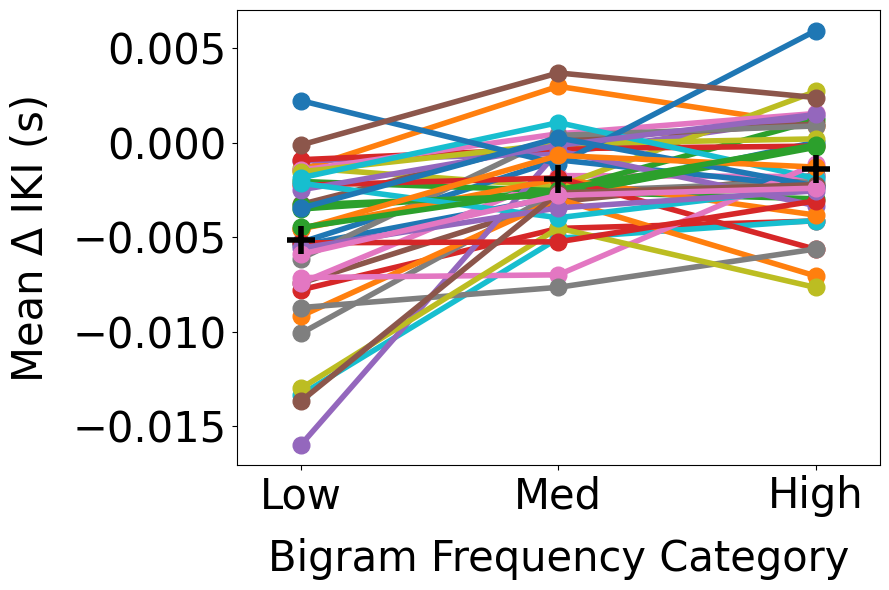

In [75]:
## plotting mean delta iki by BF group

plt.set_cmap('tab20')

x = [2, 4, 6]
D = (all_deltas_bybf[all_deltas_bybf['bf_type'] == 'low']['mean_deltaiki'],
    all_deltas_bybf[all_deltas_bybf['bf_type'] == 'med']['mean_deltaiki'],
    all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']['mean_deltaiki'])

means = (np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'low']['mean_deltaiki']),
        np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'med']['mean_deltaiki']),
        np.mean(all_deltas_bybf[all_deltas_bybf['bf_type'] == 'high']['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

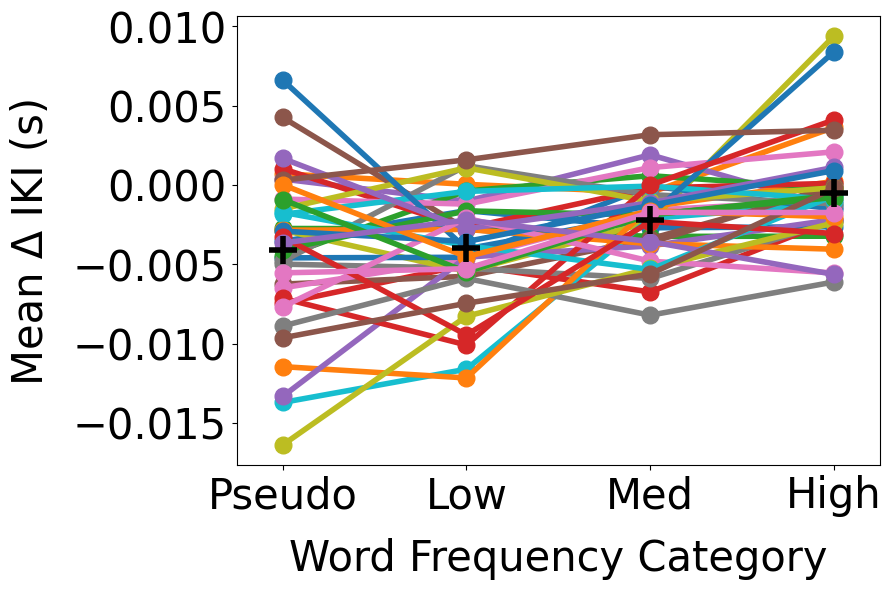

In [76]:
## plotting mean delta iki by WF group

plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (all_deltas_bywf[all_deltas_bywf['wf_type'] == 'pseudo']['mean_deltaiki'],
    all_deltas_bywf[all_deltas_bywf['wf_type'] == 'low']['mean_deltaiki'],
     all_deltas_bywf[all_deltas_bywf['wf_type'] == 'med']['mean_deltaiki'],
    all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']['mean_deltaiki'])

means = (np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'pseudo']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'low']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'med']['mean_deltaiki']),
        np.mean(all_deltas_bywf[all_deltas_bywf['wf_type'] == 'high']['mean_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([-0.129, 0.06])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meandeltaiki_bywf.png', dpi=300)
plt.show()

In [77]:
pseudo_strings = corr_trials_bybg[corr_trials_bybg['wf_type'] == 'pseudo']
pseudo_ikis = pseudo_strings.groupby(['sID', 'rep_num']).IKI.agg(['mean']).reset_index()

<Figure size 640x480 with 0 Axes>

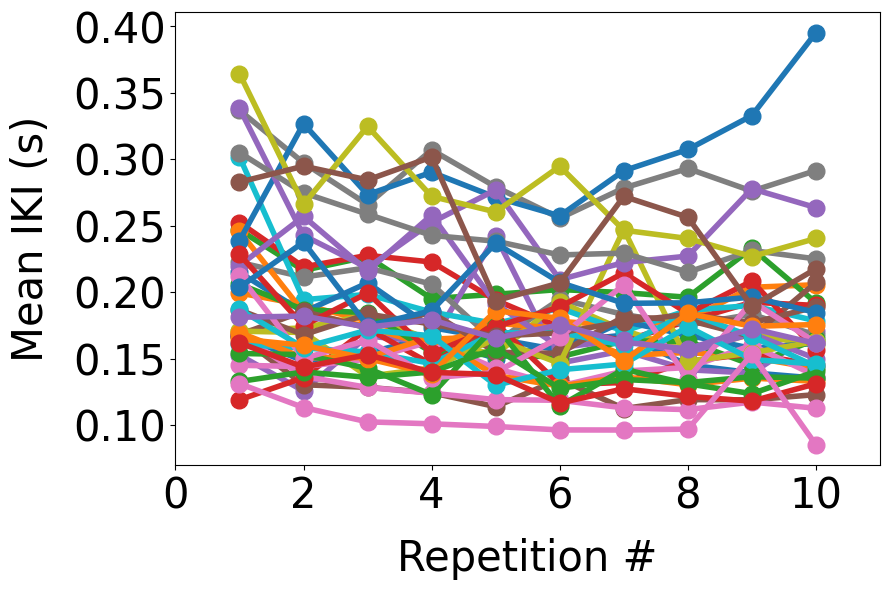

In [78]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = list(range(1,11))
D = (pseudo_ikis[pseudo_ikis['rep_num'] == 0]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 1]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 2]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 3]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 4]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 5]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 6]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 7]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 8]['mean'],
    pseudo_ikis[pseudo_ikis['rep_num'] == 9]['mean'])

# means = (np.mean(mean_rts[mean_rts['wf_type'] == 'pseudo']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'lowwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'medwf']['key_resp.rt.1']),
#         np.mean(mean_rts[mean_rts['wf_type'] == 'highwf']['key_resp.rt.1']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
# ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

# plt.ylim([0.6, 0.65])
plt.xlim([0, 11])
plt.xticks(fontsize=30)
plt.xlabel("Repetition #", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize=30)

plt.title("")
ax.grid(False)

fig.tight_layout()
plt.savefig(save_dir + '/meaniki_byrep.png', dpi=300)
plt.show()

## High BF/WF IKIs vs. Simulated Null

Average of shuffled mean delta IKIs 7.729117055382589e-06
Mean delta IKI of collected high BF bigrams -0.0013108656253903225
estimated p-val: 0.0


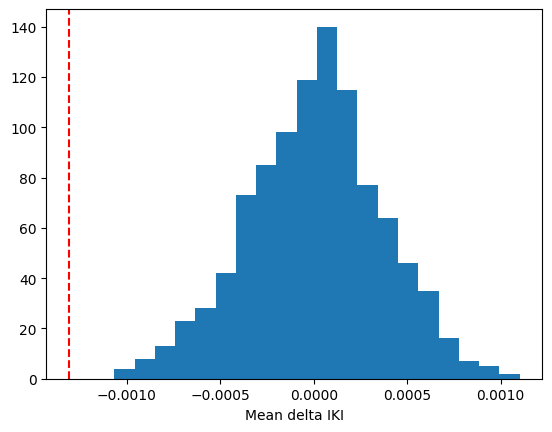

In [100]:
# Plotting mean delta IKIs of shuffled data and collected high BF bigrams
highbf_mean = corr_trials_bybg[corr_trials_bybg['bf_type'] == 'high'].delta_iki.mean()
shuff_iki = null_deltas(corr_trials_bybg, 'IKI')
shuff_highbf = shuff_iki[shuff_iki[0] == 'bf_type']

print('Average of shuffled mean delta IKIs', np.mean(shuff_highbf[1]))
print('Mean delta IKI of collected high BF bigrams', highbf_mean)
print('estimated p-val:', np.mean(abs(shuff_highbf[1]) > abs(highbf_mean)))

plt.hist(shuff_highbf[1], bins=20)
plt.axvline(x=highbf_mean, color='red', linestyle='--')

plt.xlabel("Mean delta IKI")
plt.title("")

plt.show()

Average of shuffled mean delta IKIs 6.244384042815246e-07
Mean delta IKI of collected high WF bigrams -0.0006746880306617382
estimated p-val: 0.092


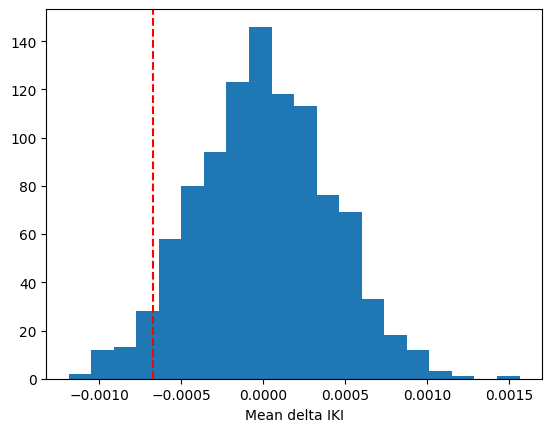

In [101]:
# Plotting mean delta IKIs of shuffled data and collected high WF bigrams
highwf_mean = corr_trials_bybg[corr_trials_bybg['wf_type'] == 'high'].delta_iki.mean()
shuff_highwf = shuff_iki[shuff_iki[0] == 'wf_type']

print('Average of shuffled mean delta IKIs', np.mean(shuff_highwf[1]))
print('Mean delta IKI of collected high WF bigrams', highwf_mean)
print('estimated p-val:', np.mean(abs(shuff_highwf[1]) > abs(highwf_mean)))

plt.hist(shuff_highwf[1], bins=20)
plt.axvline(x=highwf_mean, color='red', linestyle='--')

plt.xlabel("Mean delta IKI")
plt.title("")

plt.show()

# Total Delta IKI

## Total Delta IKI Statistics

In [ ]:
# Calculates delta IKI between first and final trial 
# (last rep IKI - first rep IKI)

def total_deltaiki(dataframe):
    DF = dataframe[dataframe['rep_num'].isin([0,9])]
    total_delta = pd.DataFrame(DF.groupby(['sID', 'string', 'bigram']).IKI.agg(['diff']))
    total_delta.fillna(0, inplace=True)
    if 'total_deltaiki' in dataframe.columns:
        dataframe.replace(dataframe['total_deltaiki'], total_delta)
    else:
        dataframe.insert(len(dataframe.columns), 'total_deltaiki', total_delta)
    last_trials = dataframe[dataframe['rep_num'] == 9]
    return last_trials

# Calculates individual mean of total delta IKI for each subject.
def indiv_totaldeltaiki(dataframe, str_or_bg, typ_group_list):
    all_means = pd.DataFrame()
    for typ_group in typ_group_list:
        all_metrics_bygroup = pd.DataFrame()
        group = getattr(typ, typ_group)
        if str_or_bg == 'string':
            DF = dataframe[dataframe.string.isin(group)]
        elif str_or_bg == 'bigram':
            DF = dataframe[dataframe.bigram.isin(group)]
        totaldelta_DF = total_deltaiki(DF)
        totaldelta_DF = totaldelta_DF[totaldelta_DF['rep_num'] != 0]
        deltas = totaldelta_DF.groupby(['sID', 
                                        'string', 
                                        'bigram']).total_deltaiki.agg(['mean']).reset_index()
        deltas = deltas.rename(columns={'mean': 'total_deltaiki'})
        total_deltaikis = deltas.groupby('sID').total_deltaiki.agg(['mean']).reset_index()
        total_deltaikis = total_deltaikis.rename(columns={'mean': 
                                                          'total_deltaiki'})
        if str_or_bg == 'string':
            if 'avg' in typ_group:
                freq_type = typ_group
                exclude_chars = ['avg_', 'bf']
                for char in exclude_chars:
                    freq_type = freq_type.replace(char, "")
                total_deltaikis['avgbf_type'] = freq_type
            else:
                freq_type = typ_group.replace('wf', "")
                total_deltaikis['wf_type'] = freq_type
        elif str_or_bg == 'bigram':
             freq_type = typ_group.replace('bf', "")
             total_deltaikis['bf_type'] = freq_type
        all_means = pd.concat([all_means, total_deltaikis])
    return all_means.reset_index(drop=True)

In [ ]:
# indiv_totaldeltaiki(corr_trials_bybg, 'bigram', bf_groups)
# total_deltaiki(corr_trials_bybg)

In [ ]:
# anova comparing total delta IKI across BF
all_totaldeltas_bybf = indiv_totaldeltaiki(corr_trials_bybg, 'bigram', bf_groups)

print(pg.rm_anova(all_totaldeltas_bybf, 'total_deltaiki', 'bf_type', 'sID'))
pg.pairwise_tukey(all_totaldeltas_bybf, 'total_deltaiki', 'bf_type', effsize='cohen')

In [ ]:
# anova comparing total delta IKI across BF
all_totaldeltas_bywf = indiv_totaldeltaiki(corr_trials_bybg, 'string', wf_groups)

print(pg.rm_anova(all_totaldeltas_bywf, 'total_deltaiki', 'wf_type', 'sID'))
pg.pairwise_tukey(all_totaldeltas_bywf, 'total_deltaiki', 'wf_type', effsize='cohen')

## Total Delta IKI Figures

In [ ]:
## plot pseudo ods over trials across individuals
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = [2, 4, 6, 8]
D = (all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'pseudo']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'low']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'med']['total_deltaiki'],
    all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'high']['total_deltaiki'])

means = (np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'pseudo']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'low']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'med']['total_deltaiki']),
        np.mean(all_totaldeltas_bywf[all_totaldeltas_bywf['wf_type'] == 'high']['total_deltaiki']))

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-0.149, 0.060])
plt.xlim([1.5, 8.5])
plt.xticks(x, ('Pseudo', 'Low', 'Med', 'High'), fontsize=30)
plt.xlabel("Word Frequency Category", labelpad=15, fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel("Mean Total Δ IKI (s)", labelpad=15, fontsize=30)

plt.title("")

fig.tight_layout()
plt.savefig(save_dir + '/totaldeltaiki_bywf.png', dpi=300)
plt.show()

## Total Delta IKI across Bigram Location

In [ ]:
# Comparing Mean Total Delta IKI across bigram locations
deltas = total_deltaiki(corr_trials_bybg)
total_deltaiki_byloc = deltas.groupby(['sID', 'bigram_loc']).total_deltaiki.agg('mean')
total_deltaiki_byloc = pd.DataFrame(total_deltaiki_byloc).reset_index()

print(pg.rm_anova(total_deltaiki_byloc, 'total_deltaiki', 'bigram_loc', 'sID'))
pg.pairwise_tukey(total_deltaiki_byloc, 'total_deltaiki', 'bigram_loc', effsize='cohen')

In [ ]:
# Plotting Mean Total Delta IKI across bigram locations

diffs = deltas[deltas['rep_num'] == 9].sort_values(by=['sID', 'string'])
indiv_diffs = pd.DataFrame(diffs.groupby(['sID', 
                                          'bigram_loc']).total_deltaiki.agg('mean')).reset_index()

x = (2, 4, 6, 8)
D = (indiv_diffs.groupby(['bigram_loc']).total_deltaiki.mean())
st_dev = (indiv_diffs.groupby(['bigram_loc']).total_deltaiki.std())

fig, ax = plt.subplots(figsize=(9, 6))
plt.errorbar(x, D, st_dev, c='r')
plt.show()

# Repetition Effects

In [ ]:
# Mean IKI of first reps vs mean IKI of last reps by individual (across all categories)
rep1 = corr_trials_bybg[corr_trials_bybg['rep_num'] == 0]
rep1_meaniki = rep1.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)
rep1_rt = rep1[rep1['bigram_loc'] == 0]
rep1_meanrt = rep1_rt.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)

rep10 = corr_trials_bybg[corr_trials_bybg['rep_num'] == 9]
rep10_meaniki = rep10.groupby('sID').IKI.agg('mean').reset_index(drop=True)
rep10_rt = rep10[rep10['bigram_loc'] == 0]
rep10_meanrt = rep10_rt.groupby('sID').IKI.agg(['mean']).reset_index(drop=True)

print('mean IKI:')
print(pg.ttest(rep1_meaniki['mean'], rep10_meaniki, paired=True))
print('mean RT:')
print(pg.ttest(rep1_meanrt['mean'], rep10_meanrt['mean'], paired=True))

In [ ]:
# ## plotting overall bg repetition effect
# plt.rcParams.update(plt.rcParamsDefault)
# # plt.style.use('fast')
# plt.set_cmap('tab20')

# x = ('first_rep', 'last_rep')
# D = (rep1_meaniki.mean.mean(), rep10_meaniki.mean.mean())
# sds = (rep1_meaniki.mean.std(), rep10_meaniki.mean.std())

# plt.bar(x, D, color = 'deepskyblue', width = 0.4)
# plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

# plt.show()

In [ ]:
## repetition effect of high freq bgs
highbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_firstrep = highbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'high')].reset_index()
highbf_lastrep = highbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highbf_diffs = (highbf_lastrep.IKI - highbf_firstrep.IKI)

## repetition effect of low freq bgs
lowbf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_firstrep = lowbf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowbf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['bf_type'] == 'low')].reset_index()
lowbf_lastrep = lowbf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowbf_diffs = (lowbf_lastrep.IKI - lowbf_firstrep.IKI)

pg.ttest(highbf_diffs, lowbf_diffs)
highbf_lastrep

In [ ]:
## plotting repetition effect on high vs low freq bgs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high bf', 'low bf')
D = (highbf_diffs.mean(), lowbf_diffs.mean())
sds = (highbf_diffs.std(), lowbf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [ ]:
## repetition effect of high freq wfs
highwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_firstrep = highwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
highwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'high')].reset_index()
highwf_lastrep = highwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

highwf_diffs = (highwf_lastrep.IKI - highwf_firstrep.IKI).reset_index(drop=True)

## repetition effect of low freq wfs
lowwf_firstrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 0) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_firstrep = lowwf_firstrep.sort_values(by=['sID', 'string', 'bigram_loc'])
lowwf_lastrep = corr_trials_bybg[(corr_trials_bybg['rep_num'] == 9) & (corr_trials_bybg['wf_type'] == 'low')].reset_index()
lowwf_lastrep = lowwf_lastrep.sort_values(by=['sID', 'string', 'bigram_loc'])

lowwf_diffs = (lowwf_lastrep.IKI - lowwf_firstrep.IKI).reset_index(drop=True)

pg.ttest(highwf_diffs, lowwf_diffs)

In [ ]:
## plotting repetition effect on high vs low freq wfs
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('fast')
plt.set_cmap('tab20')

x = ('high wf', 'low wf')
D = (highwf_diffs.mean(), lowwf_diffs.mean())
sds = (highwf_diffs.std(), lowwf_diffs.std())

plt.bar(x, D, color = 'deepskyblue', width = 0.4)
plt.errorbar(x, D, yerr=sds, fmt="o", color="b")

plt.show()

In [ ]:
x = [(2, 4, 6, 8), (2, 4, 6, 8)]
D = [first_reps.groupby('bigram_loc').IKI.mean(),
     last_reps.groupby('bigram_loc').IKI.mean()]
st_dev = [first_reps.groupby('bigram_loc').IKI.std(),
          last_reps.groupby('bigram_loc').IKI.std()]

fig, ax = plt.subplots(figsize=(9, 6))
# ax.plot(x, D, '.-', linewidth=4, ms=24)
plt.errorbar(x[0], D[0], st_dev[0], c='r')
plt.errorbar(x[1], D[1], st_dev[1], c='b')

plt.show()

# Individual Differences

## Sensitivity to individual differences

In [ ]:
## calculating senstivity to individual differences (with weird metric I made up)
# D = pd.concat([indiv_meanikis(corr_trials_bybg, 'bigram', 'lowbf'), 
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'medbf'),
#      indiv_meanikis(corr_trials_bybg, 'bigram', 'highbf')])

# high_bf

# np.mean(choose2(D['Avg IKI'], operation = abs_difference))
perms = list(it.permutations(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'], 2))
# for x in perms:
#     abs(x[1] - x[2])

sample_diffs = [abs(x[0] - x[1]) for x in perms]
indiv_sens = np.mean(sample_diffs)/np.mean(indiv_sdikis(corr_trials_bybg, 'bigram', 'medbf')['Avg SD IKI'])
indiv_sens

In [ ]:
## Pearson correlation between low and high bigram freq. Mean IKIs
print(pearsonr(all_bybf[all_bybf['bf_type'] == 'low']['mean_IKI'], 
               all_bybf[all_bybf['bf_type'] == 'high']['mean_IKI']))

## Pearson correlation between low and high bigram freq. Mean SD IKIs
print(pearsonr(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'], 
               all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI']))

## Pearson correlation between low and high bigram freq. Mean CV IKIs
print(pearsonr(all_bybf[all_bybf['bf_type'] == 'low']['cv_IKI'], 
               all_bybf[all_bybf['bf_type'] == 'high']['cv_IKI']))

In [ ]:
## Pearson correlation between low and high word freq. Mean IKIs
print(pearsonr(all_bywf[all_bywf['wf_type'] == 'pseudo']['mean_IKI'], 
               all_bywf[all_bywf['wf_type'] == 'high']['mean_IKI']))

## Pearson correlation between low and high word freq. Mean SD IKIs
print(pearsonr(all_bywf[all_bywf['wf_type'] == 'pseudo']['sd_IKI'], 
               all_bywf[all_bywf['wf_type'] == 'high']['sd_IKI']))

## Pearson correlation between low and high word freq. Mean CV IKIs
print(pearsonr(all_bywf[all_bywf['wf_type'] == 'pseudo']['cv_IKI'], 
               all_bywf[all_bywf['wf_type'] == 'high']['cv_IKI']))

In [ ]:
##plotting sd correlation
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'], 
            all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI'], 
            s = 70, color = 'red')

z = np.polyfit(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'], 
               all_bybf[all_bybf['bf_type'] == 'high']['sd_IKI'], 1)
p = np.poly1d(z)
plt.plot(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI'],
         p(all_bybf[all_bybf['bf_type'] == 'low']['sd_IKI']),
         color = 'red')

plt.xlabel("Mean SD IKI (Low)", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (High)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
# plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'SD_correlation_bysub', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## Individual metrics across all bigrams/trials for Turbo analysis

In [ ]:
# Calcuating individual metrics across all trials/bigrams
iki_global = indiv_ikimetric(corr_trials_bybg, 'string', no_groups, iki_metrics)
rt_global = indiv_rtmetric(corr_trials, no_groups, iki_metrics)
deltaiki_global = indiv_meandeltaiki(corr_trials_bybg, 'string', no_groups)
totaldeltaiki_global = indiv_totaldeltaiki(corr_trials_bybg, 'string', no_groups)
deltart_global = indiv_deltart(corr_trials, no_groups)
error_global = all_ikimetric(indiv_error, incorr_bgs, 'string', no_groups)

# Concetenating into one dataframe and exporting to .csv.
indiv_globalmetrics = pd.concat([iki_global,
                                 rt_global,
                                 deltaiki_global,
                                 totaldeltaiki_global,
                                 deltart_global,
                                 error_global], axis = 1)
indiv_globalmetrics = indiv_globalmetrics.loc[:, ~indiv_globalmetrics.columns.duplicated()]
indiv_globalmetrics = indiv_globalmetrics.drop(['wf_type', 'index'], axis = 1)

indiv_globalmetrics.to_csv(save_dir + '/indiv_globalmetrics.csv')

# GRAPHS
___

## Data Visualization
___

In [ ]:
## bigram frequency distribution
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(typ.bg_freqs['Bigrams'], typ.bg_freqs['Frequency'])

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
bg_freq = plt.scatter(all_bigrams['bg_freq'], all_bigrams['IKI'])

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## Histogram of bigram frequencies
plt.figure(figsize=(50, 10))
bg_freq = plt.hist(all_bigrams['bg_freq'], bins = 100)

plt.xlabel("Chosen Bigrams")
plt.ylabel("Bigram Freq.")
plt.title("")

plt.show()

In [ ]:
## IKI by Bigram Frequency
plt.figure(figsize=(50, 10))
# bg_freq = plt.scatter(all_bigrams[all_bigrams.sID == 's175']['bg_freq'], all_bigrams[all_bigrams.sID == 's175']['IKI'])

# sns.scatterplot(data = all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')], 
#                x = 'bg_freq', y = 'IKI')
    
    
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'there')]['IKI'], c='r')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'therm')]['IKI'], c='b')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'think')]['IKI'], c='g')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'theme')]['IKI'], c='k')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'tithe')]['IKI'], c='m')
plt.scatter(all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['bg_freq'], 
                      all_bigrams[(all_bigrams.sID == 's175') & (all_bigrams.string == 'edthe')]['IKI'], c='y')

plt.ylabel("IKI")
plt.xlabel("Bigram Freq.")
plt.title("")
plt.ylim([0, 0.25])

plt.show()

In [ ]:
## making data frames with for individual stats for each bigram
cvs = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg([variation])).reset_index()
for index, bg in enumerate(cvs['bigram']):
    if bg in list(typ.highbf):
        cvs.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        cvs.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        cvs.loc[index, 'bf_type'] = 'Low'     

sds = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['std'])).reset_index()
for index, bg in enumerate(sds['bigram']):
    if bg in list(typ.highbf):
        sds.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        sds.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        sds.loc[index, 'bf_type'] = 'Low' 

ikis = pd.DataFrame(corr_trials_bybg.groupby(['sID', 'bigram']).IKI.agg(['mean'])).reset_index()
for index, bg in enumerate(ikis['bigram']):
    if bg in list(typ.highbf):
        ikis.loc[index, 'bf_type'] = 'High'
    elif bg in list(typ.medbf):
        ikis.loc[index, 'bf_type'] = 'Med'
    elif bg in list(typ.lowbf):
        ikis.loc[index, 'bf_type'] = 'Low'

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(ikis)

In [ ]:
## plot showing distribution of bigram frequency types across each position in the string
locs = [0, 1, 2, 3]
type_list = ['high', 'med', 'low']
        
high = [6, 8, 7, 7]
med = [10, 8, 9, 8]
low = [8, 8, 8, 9]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high, width=width, 
        color='b', label='high bf')
plt.bar(indices, med, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks([0, 1, 2, 3])
plt.xlabel("IKI position")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

In [ ]:
## number of bigrams in each freq. type across word freq. categories
for wf_type in wf_groups:
    bf_in_wf = 0
    wf = getattr(typ, wf_type)
    for bf_type in bf_groups:
        bf = getattr(typ, bf_type)
        for bigram in bf:
            for string in wf:
                if bigram in string:
                    bf_in_wf = bf_in_wf + 1
        print(bf_in_wf, bf_type, 'in', wf_type)

In [ ]:
## number of bigrams in each freq. type across word freq. categories
locs = [0, 1, 2, 3]
type_list = ['high_bf', 'med_bf', 'low_bf']
        
high_bf = [24, 24, 24, 24]
med_bf = [16, 14, 18, 15]
low_bf = [12, 6, 5, 5]

plt.figure(figsize=(10, 7))
indices = np.arange(len(high))
width = 0.8

plt.bar(indices, high_bf, width=width, 
        color='b', label='high bf')
plt.bar(indices, med_bf, 
        width=0.75*width, color='r', alpha=0.5, label='med bf')
plt.bar(indices, low_bf, 
        width=0.25*width, color='y', alpha=0.5, label='low bf')

plt.xticks(locs, ['pseudo', 'low', 'med', 'high'])
plt.xlabel("WF")
plt.ylabel("# of bigrams")

plt.legend(loc = 'lower left', labelcolor = 'k')

plt.show()

In [ ]:
typ.bg_freqs[typ.bg_freqs['Bigrams'].isin(typ.lowbf)]

## BG FREQ GRAPHS
___

In [ ]:
## plotting BF distribution of data set
high_bgs = typ.bg_freqs.loc[0:15]
med_bgs = typ.bg_freqs.loc[15:46]
low_bgs = typ.bg_freqs.loc[46:69]

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'white')
whiskerprops = dict(linewidth=2, color = 'white')
capprops = dict(linewidth=2, color = 'white')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low BF', 'Med BF', 'High BF'))
plt.xlabel("Bigram Frequency Category", labelpad=15)

# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency", labelpad=15)

plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('black')
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

fig.tight_layout()
plt.savefig(save_dir + 'bf.png', dpi=300)
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

boxprops = dict(linestyle='-', linewidth=2, color = 'black')
whiskerprops = dict(linewidth=2, color = 'black')
capprops = dict(linewidth=2, color = 'black')
flierprops = dict(markerfacecolor='royalblue', markersize=10)
medianprops = dict(linewidth=2, color='red')

ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
          flierprops=flierprops, medianprops=medianprops)

plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'))
plt.xlabel("Bigram Frequency Category", labelpad=15)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'wf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

## Bigram-Word Interaction
___

In [ ]:
## prints number of repetitions of each bigram within the string bank
rep_df = pd.DataFrame()
for bigram in typ.all_bigrams:
    rep_num = 0
    for string in typ.all_strings:
        if bigram in string:
            rep_num = rep_num + 1
    # print(bigram, rep_num)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'edthe' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("cornflowerblue")
    pc.set_edgecolor("cornflowerblue")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('he', 'eo', 'on', 'nd'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'heond_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'think' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("tomato")
    pc.set_edgecolor("tomato")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'hi', 'in', 'nk'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'think_dist.png', dpi=300, transparent = True)

In [ ]:
## plot showing iki distributions for all bigrams in one word (correct trials, all individuals)

string = 'theme' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
# sns.violinplot(data=DF, palette='tab20').set(title = string)

fig, ax = plt.subplots(figsize=(9, 6))
ax.set_facecolor('black')

violin = ax.violinplot(DF, showmeans = True)
for pc in violin["bodies"]:
    pc.set_facecolor("goldenrod")
    pc.set_edgecolor("goldenrod")
    pc.set_alpha(1)
    
for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
    vp = violin[partname]
    vp.set_edgecolor("lightcyan")
    vp.set_linewidth(2)
    
plt.ylim([0, 1])
plt.xticks((1, 2, 3, 4), ('th', 'he', 'em', 'me'))
plt.xlabel("Bigram within word", labelpad=15)
plt.ylabel("IKI (s)", labelpad=15)

fig.tight_layout()
plt.savefig(save_dir + 'theme_dist.png', dpi=300, transparent = True)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, one individual)    
strings_with_onesub = pd.DataFrame()
for string in typ.all_strings:
    bigram = 'th' ## edit bigram of interest here
    if bigram in string:
         strings_with_onesub[string] = corr_trials_bybg[(corr_trials_bybg.sID == 's180') ## edit sID here 
                                              & (corr_trials_bybg.bigram == bigram) 
                                              & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
strings_with_onesub

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with_onesub)

In [ ]:
## distribution of a bigram's IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()

for string in typ.all_strings:
        bigram = 'he' ## edit bigram of interest here
        if bigram in string:
                temp = corr_trials_bybg[(corr_trials_bybg.bigram == bigram) 
                                        & (corr_trials_bybg.string == string)]['IKI'].reset_index(drop = True)
                strings_with[string] = temp

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
## distribution of a bigram's ~INDIVIDUAL MEAN~ IKIs for each word it occurs in (correct trials, all individuals)
strings_with = pd.DataFrame()
for index, ID in enumerate(ID_list):
    strings_with.loc[index, 'sID'] = ID
    for string in typ.all_strings:
        bigram = 're' ## edit bigram of interest here
        if bigram in string:
             strings_with.loc[index, string] = corr_trials_bybg[(corr_trials_bybg.sID == ID) 
                                                  & (corr_trials_bybg.bigram == bigram) 
                                                  & (corr_trials_bybg.string == string)]['IKI'].mean()

strings_with

sns.set(rc={"figure.figsize":(8, 4)})
sns.violinplot(data=strings_with)

In [ ]:
string = 'heond' ## edit string here
DF = corr_trials[corr_trials.string == string]
DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
bgs = typ.bi_byword(string)
DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})

# sns.set(rc={"figure.figsize":(8, 4)})
fig, ax = plt.subplots()
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
sns.violinplot(data=DF, palette='tab20', ax=ax).set(title = string)
ax.set_ylim(-0.02,1)
plt.show()

In [ ]:
## plot showing iki distributions for bigrams in each word (correct trials, all individuals)
fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)
#axs.set_ylim([0,2])

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[corr_trials.string == string]
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])
        

In [ ]:
## plot showing iki distributions for bigrams in each word for one participant (correct trials)

fig, axs = plt.subplots(8, 3, figsize=(25, 25))
fig.subplots_adjust(hspace=0.3)

for y, freq in enumerate(typ.avgbf_types):
    for x, string in enumerate(freq):
        DF = corr_trials[(corr_trials.string == string)
                        & (corr_trials.sID == 's175')] ## change ID here
        DF = DF[['iki_1', 'iki_2', 'iki_3', 'iki_4']]
        bgs = typ.bi_byword(string)
        DF = DF.rename(columns={'iki_1':bgs[0], 'iki_2':bgs[1], 'iki_3':bgs[2], 'iki_4':bgs[3]})
        sns.violinplot(data=DF, ax=axs[x,y]).set(title = string)
        axs[x,y].set_ylim([-0.1,1])

In [ ]:
def wf_order_effects(bigram, first_wf, second_wf):
    b2b = pd.DataFrame()
    for sID in ID_list:
        DF = pd.DataFrame(corr_trials_bybg[(corr_trials_bybg['sID'] == sID) 
                          & (corr_trials_bybg['bigram'] == bigram)]).reset_index(drop=True)
        for index, data in enumerate(DF):
            if DF.loc[index, 'trial_num'] == DF.loc[index+1, 'trial_num'] - 1:
                if DF.loc[index, 'wf_type'] == first_wf and DF.loc[index+1, 'wf_type'] == second_wf:
                    # temp1 = pd.DataFrame(DF.loc[index]).T.reset_index(drop = True)
                    temp2 = pd.DataFrame(DF.loc[index+1]).T.reset_index(drop = True)
                    b2b = pd.concat([b2b, temp2])
    return b2b

In [ ]:
wf_order_effects('th', 'high', 'pseudo')

In [ ]:
def b2b_diff(wf1, wf2):
    DF = pd.concat([wf_order_effects('th', wf1, wf2), wf_order_effects('he', wf1, wf2)]) 
    ## only 'th' and 'he' are represnted across all WF groups
    diffs = pd.DataFrame(DF.IKI.diff()).reset_index(drop = True)
    diffs = diffs.iloc[1::2, :]
    diffs['comparison'] = (wf1 + ' to ' + wf2)
    return diffs

b2b_diff('high', 'pseudo')

In [ ]:
## anova for high to pseudo and high to high order effects on 'th' and 'he'
diffs = pd.concat([b2b_diff('pseudo', 'high'), 
                   b2b_diff('pseudo', 'med'), 
                   b2b_diff('pseudo', 'low'), 
                   b2b_diff('pseudo', 'pseudo')], ignore_index=True)
diffs['IKI'] = diffs['IKI'].astype('float64')

oe_anova = pg.anova(dv='IKI', data=diffs, between='comparison')
print(oe_anova)

In [ ]:
## plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' average IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('theme', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Average IKIs (S)")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
## box plot comparing indidivuals' CV IKI between 'th' in there and theme
x = [2, 4]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('theme', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.boxplot(D, positions=x)

plt.xticks(x, ('there', 'theme'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
# plt.ylim([0, 0.8])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_meanikis_bybg('there', 'th')['mean'], indiv_meanikis_bybg('think', 'th')['mean'], 
     indiv_meanikis_bybg('theme', 'th')['mean'], indiv_meanikis_bybg('therm', 'th')['mean'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual Avg IKIs (S)")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

In [ ]:
x = [2, 4, 6, 8]
D = (indiv_cvs_bybg('there', 'th')['variation'], indiv_cvs_bybg('think', 'th')['variation'], 
     indiv_cvs_bybg('theme', 'th')['variation'], indiv_cvs_bybg('therm', 'th')['variation'])

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x, D)

plt.xticks(x, ('there', 'think', 'theme', 'therm'))
plt.xlabel("Word 'th' was typed in")
plt.ylabel("Inividual CV IKIs")
plt.ylim([0, 0.5])
plt.title("")
# plt.legend(loc="best")

plt.show()

## Not Useful Graphs - Variables by Word and Word Type (WF and Avg. BF)
___

In [ ]:
# ## creating dataframe from 'cv_byword' function that is easy to plot
# cv_word = 'druze' # change this for which ever word you want to plot
# cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

# ## plotting digraph latency variations by word (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# # medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

# ## Set general font size
# plt.rcParams['font.size'] = '25'

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Word")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

# ## Set tick font size
# # for label in (ax.get_xticklabels() + ax.get_yticklabels()):
# #     label.set_fontsize(25)

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Interval position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 1])
# plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
# plt.legend(loc="best")

# # plt.savefig(save_dir + 'ian_iki.png')

# plt.show()

In [ ]:
# ## plotting digraph latency variations by wf_type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
# medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
# lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
# pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by wf_type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (includes error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, all_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, all_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, all_rts), color='green', label='Low bigram freq.')

# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/ error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## plotting digraph latency variations by Avg. BF type (does not include error trials)
# plt.figure(figsize=(10, 7))
# x = [0, 1, 2, 3]
# highbf_plot = plt.plot(typ.avg_cv(typ.avg_highbf, corr_rts), color='red', label='High bigram freq.')
# medbf_plot = plt.plot(typ.avg_cv(typ.avg_medbf, corr_rts), color='blue', label='Medium bigram freq.')
# lowbf_plot = plt.plot(typ.avg_cv(typ.avg_lowbf, corr_rts), color='green', label='Low bigram freq.')


# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.xlabel("Latency position in string")
# plt.ylabel("Average CV")
# plt.ylim([0, 0.8])
# plt.title("Average CV of Interkey Interval by Avg. BF Type (w/out error)")
# plt.legend(loc="best")

# plt.show()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution for IKI position in the string by WF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by WF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.highwf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High WF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.medwf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med WF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.lowwf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low WF")
# axs[1, 0].set_ylim([-0.01, 1.5])
# axs[1, 1].boxplot((typ.cv_all(typ.pseudo, all_rts).loc[:, 1:4]))
# axs[1, 1].set_title("Pseudo")
# axs[1, 1].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
# ## 4-quadrant plot showing CV IKI distribution of IKI position in the string by Avg. BF (includes error, for all words not grouped)

# figure, axs = plt.subplots(2, 2, figsize=(20, 14))
# figure.suptitle('CV IKI Distribution by Avg. BF w/ error', y=0.95)

# axs[0, 0].boxplot((typ.cv_all(typ.avg_highbf, all_rts).loc[:, 1:4]))
# axs[0, 0].set_title("High BF")
# axs[0, 0].set_ylim([-0.01, 1.5])
# axs[0, 1].boxplot((typ.cv_all(typ.avg_medbf, all_rts).loc[:, 1:4]))
# axs[0, 1].set_title("Med BF")
# axs[0, 1].set_ylim([-0.01, 1.5])
# axs[1, 0].boxplot((typ.cv_all(typ.avg_lowbf, all_rts).loc[:, 1:4]))
# axs[1, 0].set_title("Low BF")
# axs[1, 0].set_ylim([-0.01, 1.5])

# for ax in axs.flat:
#     ax.set(ylabel='CV IKI', xlabel='IKI Postion in String')

# ## Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# Tables

In [ ]:
# Makes table of all individual speed and variability IKI metrics
all_ikimetrics = pd.concat([all_bybf, 
                            all_bywf,
                            all_deltas_bybf,
                            all_deltas_bywf,
                            all_totaldeltas_bybf,
                            all_errors_bybf,
                            all_errors_bywf,
                            all_totaldeltas_bywf,
                            rt_bywf,
                            all_deltarts_bywf]).reset_index(drop=True)

# Calculates frequency category means and SDs and collects into dataframe
table_dict = {}

for freq_type in ['wf_type', 'bf_type']:
    for freq in all_ikimetrics[freq_type].unique():
        if pd.isna(freq) == False:
            col_list = ['mean_IKI', 'sd_IKI', 'cv_IKI',
                        'mean_deltaiki', 'total_deltaiki',
                        'total_error',
                        'mean_RT', 'sd_RT', 'cv_RT',
                        'mean_deltart']
            value_list = []
            for col in col_list:
                if col not in ['cv_IKI', 'cv_RT', 'mean_deltaiki', 'total_error']:
                    metric_mean = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].mean(numeric_only=True)
                    mean_2sig = f"{(metric_mean*1000):.3g}"
                    metric_sd = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].std(numeric_only=True)
                    sd_2sig = f"{(metric_sd*1000):.3g}"
                    value_list.append(("{} ± {}").format(mean_2sig, 
                                                         sd_2sig))
                elif col in ['mean_deltaiki']:
                    metric_mean = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].mean(numeric_only=True)
                    mean_2sig = f"{(metric_mean*1000):.2g}"
                    metric_sd = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].std(numeric_only=True)
                    sd_2sig = f"{(metric_sd*1000):.2g}"
                    value_list.append(("{} ± {}").format(mean_2sig, 
                                                         sd_2sig))
                
                elif col in ['cv_IKI', 'cv_RT', 'total_error']:
                    metric_mean = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].mean(numeric_only=True)
                    mean_2sig = f"{(metric_mean):.2g}"
                    metric_sd = all_ikimetrics[all_ikimetrics[freq_type] == freq][col].std(numeric_only=True)
                    sd_2sig = f"{(metric_sd):.2g}"
                    value_list.append(("{} ± {}").format(mean_2sig, 
                                                         sd_2sig))
            table_dict[("{}_{}").format(freq_type,freq)] = value_list

table_dict
paper_table = pd.DataFrame().from_dict(table_dict)
metric_names = ['Mean IKI (ms)',
                'SD IKI (ms)',
                'CV IKI',
                'Mean ΔIKI (ms)',
                'Total ΔIKI (ms)',
                'Total Error',
                'Mean RT (ms)',
                'SD RT (ms)',
                'CV RT',
                'Mean ΔRT (ms)']
paper_table.insert(0, 'Metric', metric_names)
paper_table = paper_table.replace('nan ± nan', None)
paper_table.to_csv(save_dir + '/papertable1.csv')
paper_table

In [ ]:
# Creating table of values and exporting as .png
gt_df = paper_table
gt_df
col_names = ['bf_type_low',
             'bf_type_med',
             'bf_type_high',
             'wf_type_low',
             'wf_type_med',
             'wf_type_high',
             'wf_type_pseudo']
gt_papertable = (
    GT(gt_df)
    .tab_header(
        title = 'Group Averages and Standard Deviations for Collected Metrics'
    )
    .tab_spanner(label='Bigram Frequency', columns=['bf_type_low',
                                                    'bf_type_med',
                                                    'bf_type_high'])
    .tab_spanner(label='Word Frequency', columns=['wf_type_pseudo',
                                                  'wf_type_low',
                                                  'wf_type_med',
                                                  'wf_type_high'])
    .cols_label(
        bf_type_low = 'Low',
        bf_type_med = 'Medium',
        bf_type_high = 'High',
        wf_type_pseudo = 'Pseudo',
        wf_type_low = 'Low',
        wf_type_med = 'Medium',
        wf_type_high = 'High'
    )
    .tab_stub(rowname_col='Metric')
    .tab_stubhead(label='Metric')
    .sub_missing(
        columns=['bf_type_low', 'bf_type_med', 'bf_type_high'],
        missing_text="-"
    )
)

GT.save(gt_papertable, save_dir + '/paper_table.png', window_size=(7000, 7000))
gt_papertable

# Graveyard
___

# MRS Correlation
___

In [ ]:
## importing GABA quanitification .csv
## data table is edited to exclude certain data point prior to import
GABA_quant = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant_filtered.csv')
GABA_quant_nofilt = pd.read_csv(r'/Users/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/Typ_GABA_quant.csv')

GABA_sIDs = GABA_quant.sID.unique() ## making list of sIDs with GABA data

In [ ]:
## filtering corr_bgs to only have subjects with GABA data
GABA_corr_bgs = corr_bgs[corr_bgs.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_corr_trials = corr_trials[corr_trials.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_mean_rts = mean_rts[mean_rts.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
GABA_totaldeltaiki = mean_totaldeltas[mean_totaldeltas.sID.isin(GABA_sIDs)].sort_values(by='sID', ascending=True).reset_index(drop=True)
allmean_GABA_totaldeltaiki = pd.DataFrame(GABA_totaldeltaiki.groupby('sID').mean_totaldeltaiki.agg('mean')).reset_index()

In [ ]:
## calculating mean and sd iki across all bigram categories for GABA subjects only  
GABA_means = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['mean'])).reset_index().rename(columns = {'mean':'all_mean_iki'})
GABA_sds = pd.DataFrame(GABA_corr_bgs.groupby('sID').IKI.agg(['std'])).reset_index().rename(columns = {'std':'all_sd_iki'})

In [ ]:
## making filtered dataframes for the voxels of interest
# GABA_Rthal = GABA_df[(GABA_df.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)
# GABA_Lthal = GABA_df[(GABA_df.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)
# GABA_RLthal = pd.concat([GABA_Rthal, GABA_Lthal])

# GABA_RM1 = GABA_df[(GABA_df.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)
# GABA_LM1 = GABA_df[(GABA_df.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)
# GABA_RLM1 = pd.concat([GABA_RM1, GABA_LM1])

# # l_voxs = pd.concat([GABA_Lthal, GABA_LM1]).reset_index(drop=True)
# # r_voxs = pd.concat([GABA_Rthal, GABA_RM1]).reset_index(drop=True)

In [ ]:
GABA_quant_nofilt.groupby('voxel').mean(numeric_only=True).reset_index()

In [ ]:
A1_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
A2_meanGABA = GABA_quant_nofilt.groupby(['voxel']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
both_meanGABA = GABA_quant_nofilt.groupby(['voxel']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
A1_FE = GABA_quant_nofilt.groupby(['voxel']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
A2_FE = GABA_quant_nofilt.groupby(['voxel']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
both_FE = GABA_quant_nofilt.groupby(['voxel']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

by_voxel = pd.concat([A1_meanGABA, 
                      A2_meanGABA['A2_meanGABA'], 
                      both_meanGABA['both_meanGABA'], 
                      A1_FE['A1_meanFE'], 
                      A2_FE['A2_meanFE'], 
                      both_FE['both_meanFE']], 
                      axis = 1)

L_thal_shims = {'A1_shims' : [17.6, 21.5, 19, 29, 17.4, 16.9, 20.6, 23.4, 22, 19.9], 
                'A2_ shims' : [float('nan'), 21.2, 18.8, 28.9, float('nan'), 16.8, 21.4, 22.4, 22, 20]}
Lthal_shims = pd.DataFrame(L_thal_shims).reset_index(drop = True)

only_Lthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'L_thal'].reset_index(drop = True)
only_Lthal = pd.concat([only_Lthal, Lthal_shims], axis = 1)
only_Lthal = only_Lthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')


R_thal_shims = {'A1_shims' : [18.9, 21.7, 18.3, 30.2, 18.1, 17.8, 19.1, 20.1, 24.3, 21.5],
                'A2_ shims' : [float('nan'), 20.7, 18.4, 31.2, float('nan'), 17.7, 19.8, 19.8, 23.1, 22]}
Rthal_shims = pd.DataFrame(R_thal_shims).reset_index(drop = True)
only_Rthal = GABA_quant_nofilt[GABA_quant_nofilt.voxel == 'R_thal'].reset_index(drop = True)
only_Rthal = pd.concat([only_Rthal, Rthal_shims], axis = 1)
only_Rthal = only_Rthal.drop(['voxel', 'A1_GABA_Cr', 'A2_GABA_Cr', 'Mean_GABA_Cr'], axis='columns')

only_Rthal

# A1_meanGABA = only_thal.groupby(['sID']).A1_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanGABA'})
# A2_meanGABA = only_thal.groupby(['sID']).A2_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanGABA'})
# both_meanGABA = only_thal.groupby(['sID']).Mean_GABA_Cr.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanGABA'})
# A1_FE = GABA_quant_nofilt.groupby(['sID']).A1_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A1_meanFE'})
# A2_FE = GABA_quant_nofilt.groupby(['sID']).A2_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'A2_meanFE'})
# both_FE = GABA_quant_nofilt.groupby(['sID']).Mean_FE.agg(['mean']).reset_index().rename(columns={'mean' : 'both_meanFE'})

# by_sID = pd.concat([A1_meanGABA, 
#                       A2_meanGABA['A2_meanGABA'], 
#                       both_meanGABA['both_meanGABA'], 
#                       A1_FE['A1_meanFE'], 
#                       A2_FE['A2_meanFE'], 
#                       both_FE['both_meanFE']], 
#                       axis = 1)

In [ ]:
## making summary df with all relevant info
GABA_df = pd.concat([pd.DataFrame(GABA_sIDs),
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg IKI'],
                     indiv_meanikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg IKI'],
                     GABA_means['all_mean_iki'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'lowbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'medbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', 'highbf')['Avg SD IKI'],
                     indiv_sdikis(GABA_corr_bgs, 'bigram', list(typ.all_bigrams))['Avg SD IKI'],
                     GABA_sds['all_sd_iki'],
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'pseudo']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'lowwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     GABA_mean_rts[GABA_mean_rts['wf_type'] == 'medwf']['mean_RT'].reset_index(drop=True),
                     indiv_meandeltaod(GABA_corr_trials, typ.pseudo)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.lowwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.medwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, typ.highwf)['mean_deltaod'],
                     indiv_meandeltaod(GABA_corr_trials, list(typ.all_bigrams))['mean_deltaod'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.pseudo)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.lowwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.medwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', typ.highwf)['mean_deltaiki'],
                     indiv_meandeltaiki(GABA_corr_bgs, 'string', list(typ.all_bigrams))['mean_deltaiki'],
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'pseudo']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'low']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'med']['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_totaldeltaiki[GABA_totaldeltaiki['wf_type'] == 'high']['mean_totaldeltaiki'].reset_index(drop=True),
                     allmean_GABA_totaldeltaiki['mean_totaldeltaiki'].reset_index(drop=True),
                     GABA_quant[(GABA_quant.voxel == 'R_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_thal')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'R_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr'],
                     GABA_quant[(GABA_quant.voxel == 'L_M1')].sort_values('sID').reset_index(drop=True)['Mean_GABA_Cr']],
                     axis=1).reset_index(drop=True)

labels = ['sID', 
          'low_mean_iki',
          'med_mean_iki',
          'high_mean_iki',
          'all_avg_mean_iki',
          'all_mean_iki',
          'low_sd_iki', 
          'med_sd_iki', 
          'high_sd_iki', 
          'all_avg_sd_iki',
          'all_sd_iki',
          'pseudo_od',
          'low_od',
          'med_od',
          'high_od',
          'pseudo_deltaod',
          'low_deltaod',
          'med_deltaod',
          'high_deltaod',
          'all_deltaod',
          'pseudo_deltaiki',
          'low_deltaiki',
          'med_deltaiki',
          'high_deltaiki',
          'all_deltaiki',
          'pseudo_totaldeltaiki',
          'low_totaldeltaiki',
          'med_totaldeltaiki',
          'high_totaldeltaiki',
          'all_totaldeltaiki',
          'R_thal_GABA', 
          'L_thal_GABA', 
          'R_M1_GABA', 
          'L_M1_GABA']
GABA_df.columns = labels

## adding column with difference between low and high sd iki
GABA_df['delta_sd_iki'] = GABA_df['low_sd_iki'] - GABA_df['high_sd_iki']
# GABA_df = GABA_df.drop(list(range(10,17)))
GABA_df

# print(np.std(GABA_df.low_sd_iki))
# print(np.std(GABA_df.med_sd_iki))
# print(np.std(GABA_df.high_sd_iki))

In [ ]:
## testing if thalamus and M1 GABA are significantly different -- fix later, but they aren't
# meanRL_thal = (GABA_Rthal['Mean_GABA_Cr'] + GABA_Lthal['Mean_GABA_Cr'])/2
# meanRL_thal = pd.concat([GABA_Lthal['sID'], meanRL_thal], axis = 1)

# meanRL_M1 = (GABA_RM1['Mean_GABA_Cr'] + GABA_LM1['Mean_GABA_Cr'])/2
# meanRL_M1 = pd.concat([GABA_LM1['sID'], meanRL_M1], axis = 1)

# no_match = ~np.logical_or(np.isnan(meanRL_thal['Mean_GABA_Cr']), np.isnan(meanRL_M1['Mean_GABA_Cr']))

# meanRL_M1_match = meanRL_M1[no_match]
# meanRL_thal_match = meanRL_thal[no_match]

# stats.ttest_rel(meanRL_thal_match['Mean_GABA_Cr'], meanRL_M1_match['Mean_GABA_Cr'])

In [ ]:
## making dataframes that are matched such that a paticipant will be excluded if they don't have data from both L and R thal voxels
# bad = ~np.logical_or(np.isnan(GABA_Rthal['Mean_GABA_Cr']), np.isnan(GABA_Lthal['Mean_GABA_Cr']))

# GABA_Lthal_match = GABA_Lthal[bad]
# GABA_Rthal_match = GABA_Rthal[bad]

# print(pearsonr(GABA_Lthal_match['Mean_GABA_Cr'], GABA_Rthal_match['Mean_GABA_Cr'])) ## comparing L and R thal GABA
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])) ## comparing L and R M1 GABA


### FIX LATER

In [ ]:
# print('L vs R thal')
# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'], GABA_Rthal['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

# print('L vs R M1')
# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'], GABA_RM1['Mean_GABA_Cr'])

# plt.xlabel("L")
# plt.ylabel("R")
# plt.title("")

# plt.show()

In [ ]:
# creating lists of sIDs that have data for each category
Rthal_sIDs = GABA_df[~np.isnan(GABA_df.R_thal_GABA)].sID.unique()
Lthal_sIDs = GABA_df[~np.isnan(GABA_df.L_thal_GABA)].sID.unique()

In [ ]:
## thal comparisons
# print('GABA correlated against low bf sds')
# # temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_lowbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_lowbf_sds = pd.concat([R_lowbf_sds, L_lowbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# temp = indiv_sdikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_sds = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_sds = temp[temp.sID.isin(Lthal_sIDS)]
# RL_highbf_sds = pd.concat([R_highbf_sds, L_highbf_sds])
# # print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_sds['Avg SD IKI']))
# # print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_RLthal['Mean_GABA_Cr'].dropna(), RL_highbf_sds['Avg SD IKI']))

print('GABA correlated against all bf sds')
R_allbf_sds = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_sd_iki']
L_allbf_sds = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_sd_iki']
print(pearsonr(R_allbf_sds, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_sds, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
R_allbf_means = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['all_avg_mean_iki']
L_allbf_means = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['all_avg_mean_iki']
print(pearsonr(R_allbf_means, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_allbf_means, GABA_df.L_thal_GABA.dropna()))

print('GABA correlated against delta sd iki')
R_delta_sd = GABA_df[GABA_df.sID.isin(Rthal_sIDs)]['delta_sd_iki']
L_delta_sd = GABA_df[GABA_df.sID.isin(Lthal_sIDs)]['delta_sd_iki']
print(pearsonr(R_delta_sd, GABA_df.R_thal_GABA.dropna()))
print(pearsonr(L_delta_sd, GABA_df.L_thal_GABA.dropna()))

# print('GABA correlated against low bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'lowbf')
# R_lowbf_cvs = temp[temp.sID.isin(Rthal_sIDs)]
# L_lowbf_cvs = temp[temp.sID.isin(Lthal_sIDs)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_lowbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI']))

# print('GABA correlated against high bf cvs')
# temp = indiv_cvikis(corr_trials_bybg, 'bigram', 'highbf')
# R_highbf_cvs = temp[temp.sID.isin(Rthal_sIDS)]
# L_highbf_cvs = temp[temp.sID.isin(Lthal_sIDS)]
# print(pearsonr(GABA_Rthal['Mean_GABA_Cr'].dropna(), R_highbf_cvs['Avg CV IKI']))
# print(pearsonr(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI']))

In [ ]:
GABA_df.pseudo_totaldeltaiki

In [ ]:
## M1 comparisons
# print('GABA correlated against low bf sds')
# print(pearsonr(GABA_RM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))
# print(pearsonr(GABA_LM1['Mean_GABA_Cr'], lowbf_sds['Avg SD IKI']))

# print('GABA correlated against high bf sds')
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_sds['Avg SD IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against high bf cvs')
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(highbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

# print('GABA correlated against low bf cvs')
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_RM1['Mean_GABA_Cr']))
# print(pearsonr(lowbf_cvs['Avg CV IKI'], GABA_LM1['Mean_GABA_Cr']))

print('GABA correlated against all bf sds')
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_sd_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all bf mean ikis')
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_avg_mean_iki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo od')
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high od')
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_od.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta od')
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta od')
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta od')
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaod.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo delta iki')
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high delta iki')
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all delta iki')
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_deltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against pseudo total delta iki')
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.pseudo_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against high total delta iki')
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.high_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

print('GABA correlated against all total delta iki')
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.R_M1_GABA.dropna()))
print(pearsonr(GABA_df.all_totaldeltaiki.dropna(), GABA_df.L_M1_GABA.dropna()))

In [ ]:
## lowbf cvs against L_thal GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_cvs['Avg CV IKI'])
# # plt.xlim([0.1, 0.13])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("lowbf cvs against L_thal GABA")

# plt.show()

In [ ]:
## lowbf cvs against L_M1 GABA

# plt.figure()
# bg_freq = plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_cvs['Avg CV IKI'])
# plt.xlabel("GABA")
# plt.ylabel("CV")
# plt.title("")

# plt.show()

In [ ]:
## highbf cvs against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf cvs against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_cvs['Avg CV IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean CV IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_highbfcv.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## lowbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), lowbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("Low Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# # plt.ylim(0.04, 0.08)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_lowbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
R_allbf_means

In [ ]:
GABA_df.L_thal_GABA.dropna()

In [ ]:
## all bf mean IKIs against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_means, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_means, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI (all Bigram Freqs.)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf mean IKIs against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_mean_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300)
plt.show()

In [ ]:
## all bf sds against L and R thalamus GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

plt.scatter(GABA_df.R_thal_GABA.dropna(), R_allbf_sds, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_thal_GABA.dropna(), L_allbf_sds, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L Thalamus GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI (all BFs)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

# plt.legend(fontsize = 17, loc="lower right")

fig.tight_layout()
# fig, ax = plt.subplots(facecolor = 'aliceblue')
plt.savefig(save_dir + 'RLthal_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## all bf sds against L and R M1 GABA
plt.rc('text', color='white')
plt.rc('axes', labelcolor='white')
plt.rc('xtick', color='white')
plt.rc('ytick', color='white')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_avg_sd_iki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean SD IKI", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")
plt.grid(visible=None)

ax.set_facecolor('black')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('white')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('white')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('white')

plt.legend(fontsize = '17',loc="lower left", facecolor = 'black')

plt.savefig(save_dir + 'RLM1_allbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## highbf sds against L_thal GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_Lthal['Mean_GABA_Cr'].dropna(), L_highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L Thalamus GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'Lthal_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## highbf sds against L_M1 GABA
# plt.rc('text', color='black')
# plt.rc('axes', labelcolor='black')
# plt.rc('xtick', color='black')
# plt.rc('ytick', color='black')

# fig, ax = plt.subplots(figsize=(9, 6))
# plt.scatter(GABA_LM1['Mean_GABA_Cr'].dropna(), highbf_sds['Avg SD IKI'], s = 70, color = 'black')
# plt.xlabel("L M1 GABA", fontsize = 30, labelpad=15)
# plt.ylabel("High Bigram Freq. Mean SD IKI", fontsize = 30, labelpad=15)
# # plt.xlim([0.1, 0.12])
# plt.xticks(fontsize = 24, rotation = 45)
# plt.yticks(fontsize = 24)
# plt.title("")

# ax.set_facecolor('white')
# ax.spines['top'].set_visible(True)
# ax.spines['top'].set_color('black')
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')
# ax.spines['right'].set_visible(True)
# ax.spines['right'].set_color('black')

# plt.savefig(save_dir + 'LM1_highbfsd.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
# plt.show()

In [ ]:
## all delta ods against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaod, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ Onset Delay (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaod.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_deltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
# all total delta ikis against L and R M1 GABA
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')
plt.scatter(GABA_df.R_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'red',
                label = 'Right')
plt.scatter(GABA_df.L_M1_GABA.dropna(), GABA_df.all_totaldeltaiki, s = 70, 
                color = 'blue',
                label = 'Left')
plt.xlabel("R and L M1 GABA/Cr", fontsize = 30, labelpad=15)
plt.ylabel("Mean Total Δ IKI (s)", fontsize = 30, labelpad=15)
plt.xticks(fontsize = 24, rotation = 45)
# plt.ylim(0.04, 0.08)
plt.xlim(0.085, 0.125)
plt.yticks(fontsize = 24)
plt.title("")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

plt.legend(fontsize = '17',loc="lower left")

plt.savefig((save_dir + '/RLM1_alldeltaiki.png'), dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

## Graphs for F31

In [ ]:
ten_sub_list = ['s181', 's182', 's183', 's189', 's190', 
           's198', 's207', 's209', 's210', 's212']

ten_sub = corr_trials_bybg[corr_trials_bybg.sID.isin(ten_sub_list)].reset_index()

In [ ]:
## individual IKI means by BF (correct trials only) PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI'], 
     indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI'],
     indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI'])
means = (np.mean(indiv_meanikis(ten_sub, 'bigram', 'lowbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'medbf')['Avg IKI']),
         np.mean(indiv_meanikis(ten_sub, 'bigram', 'highbf')['Avg IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     if index == len(ID_list)-1:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index), label = 'Individual')
#     else:
#         plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')
    
plt.xlim([1.5, 6.5])
plt.ylim([0.08, 0.4])
plt.xticks(x, ('', '', ''), fontsize = 24)
plt.xticks(x, ('Low', 'Med', 'High'))
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
plt.legend(fontsize = 17, loc="lower left")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_mean_ikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## using bigrams sorted by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI'], 
     indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI'])
means = (np.mean(indiv_cvikis(ten_sub, 'bigram', 'lowbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'medbf')['Avg CV IKI']), 
         np.mean(indiv_cvikis(ten_sub, 'bigram', 'highbf')['Avg CV IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)

ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.10, 0.4])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean CV IKI (%)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_cvikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## individual MEAN SD IKI by BF (correct trials) -- PRINT VERSION IN LIGHT MODE
plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI'], 
     indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI'],
     indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI'])
means = (np.mean(indiv_sdikis(ten_sub, 'bigram', 'lowbf')['Avg SD IKI']), 
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'medbf')['Avg SD IKI']),
         np.mean(indiv_sdikis(ten_sub, 'bigram', 'highbf')['Avg SD IKI']))

fig, ax = plt.subplots(figsize=(9, 6))

# cm = plt.get_cmap('tab20')
# for index, data in enumerate(ID_list):
#     plt.plot(x, [l[index] for l in D], '.-', linewidth = 4, ms = 24, color = cm(index))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black')

plt.xlim([1.5, 6.5])
plt.ylim([0.0, 0.10])
plt.xticks(x, ('', '', ''), fontsize = 24)
# plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
# plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Mean SD IKI (s)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

# fig.tight_layout()
plt.savefig(save_dir + 'F31_indiv_sdikis_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
incorr_ten_sub = incorr_bgs[incorr_bgs.sID.isin(ten_sub_list)].reset_index()

plt.rcParams['font.size'] = '30'
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

plt.rcParams['font.size'] = '30'
x = [2, 4, 6]
D = (indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error'], 
     indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error'],
     indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error'])

means = (np.mean(indiv_error(incorr_ten_sub, 'bigram', 'lowbf')['Total Error']), 
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'medbf')['Total Error']),
         np.mean(indiv_error(incorr_ten_sub, 'bigram', 'highbf')['Total Error']))

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(x, D, '.-', linewidth = 4, ms = 24)
    
ax.plot(x, means, '+', mew = 4, ms = 20, color = 'black', label = 'Group mean')

plt.ylim([-1, 22])
plt.xlim([1.5, 6.5])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
plt.ylabel("Indiv. Total Error", labelpad=15, fontsize = 24)

plt.title("")
# plt.legend(fontsize = 17, loc="best", facecolor = "black")

ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'F31_meanerr_bybf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none', bbox_inches = 'tight')
plt.show()

In [ ]:
## plotting BF distribution of data set -- PRINT VERSION IN LIGHT MODE
plt.rc('text', color='black')
plt.rc('axes', labelcolor='black')
plt.rc('xtick', color='black')
plt.rc('ytick', color='black')

x = [2, 4, 6]
D = (low_bgs['Frequency'], med_bgs['Frequency'], high_bgs['Frequency'])

fig, ax = plt.subplots(figsize=(9.25, 7))

violin = ax.violinplot(D, [2, 4, 6], showmeans= True)

for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)

# boxprops = dict(linestyle='-', linewidth=2, color = 'black')
# whiskerprops = dict(linewidth=2, color = 'black')
# capprops = dict(linewidth=2, color = 'black')
# flierprops = dict(markerfacecolor='royalblue', markersize=10)
# medianprops = dict(linewidth=2, color='red')

# ax.boxplot(D, positions=x, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops,
#           flierprops=flierprops, medianprops=medianprops)


plt.xlim([1, 7])
plt.xticks(x, ('Low', 'Med', 'High'), fontsize = 24)
plt.yticks(fontsize = 24)
plt.xlabel("Bigram Frequency Category", labelpad=15, fontsize = 24)
# plt.ylim([0, 0.8])
plt.ylabel("Bigram Frequency (10 mil)", labelpad=15, fontsize = 24)
plt.title("")
# plt.legend(loc="best")

ax.yaxis.offsetText.set_fontsize(18)
ax.set_facecolor('white')
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')

fig.tight_layout()
plt.savefig(save_dir + 'F31_bf.png', dpi=300, facecolor = fig.get_facecolor(), edgecolor = 'none')
plt.show()

In [ ]:
## anova for sds (by bg freq)
high_sd = indiv_sdikis(ten_sub, 'bigram', 'highbf')
high_sd['bf_type'] = 'high'
med_sd = indiv_sdikis(ten_sub, 'bigram', 'medbf_norep')
med_sd['bf_type'] = 'med'
low_sd = indiv_sdikis(ten_sub, 'bigram', 'lowbf_norep')
low_sd['bf_type'] = 'low'

sds = pd.concat([high_sd, med_sd, low_sd], ignore_index=True)
# print(sds)

sd_anova = pg.rm_anova(sds, 'Avg SD IKI', 'bf_type', 'sID')
print(sd_anova)

pg.pairwise_tukey(sds, 'Avg SD IKI', 'bf_type', effsize='cohen')